# > 10 GeV Analysis

In [1]:
%matplotlib inline
import astropy.io.fits as pyfits
import pywcs
from math import degrees
from astropy import units as u
from astropy import constants as c
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy.table import Table
import yaml
import pandas as pd
from pandas.tools.plotting import scatter_matrix
pd.options.display.mpl_style = 'default'
import numpy as np
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import os, sys, re
from collections import defaultdict
import cPickle as pickle
import fnmatch
import aplpy
import pyregion as pyr
from pyJam.utilities.sortNumStrings import *
from scipy.spatial.distance import pdist,cdist,squareform
import pyJam.utilities.diskGauss_68_99 as dgr68
from pyJam.utilities.shiftCmap import * 
import prettyplotlib as ppl
#from PIL import Image as pimage #this doens't work right on OS X?
from prettyplotlib import brewer2mpl
from IPython.display import display, Image
#from glob import glob
import glob
import cPickle as pickle
from bs4 import BeautifulSoup
home = os.environ['HOME']
desk = os.path.join(home,'Desktop')


In [3]:
def chkSep(cat1,cat2,minSep = 0.2,n = 1):
    """Don't want any sources too close to each other
       astropy.coordinates.match_coordinates_sky employs a kd_tree to check for neareast neighbor in 2 catalogs
       cat1/2: must be astopy SkyCorr
       minSep: min allowable separation between any two sources
       n: nth neighbor. 1 for different catalogs, 2 for comparing the same catalog
       return: indMin: index array of # of sources that are overlapping still
    """

    indSep,sep,_ = cat1 .match_to_catalog_sky(cat2,nthneighbor=n) #2 to not check source against itself. indSep is an array with indices for closest neighbor, indSep[1] = 138 means source 1's closest neighbor is source 138 (and vive versa)
    indMin = np.where(sep.degree < minSep)

    return indMin, indSep, sep

In [4]:
#write reg file
def writeReg(DF,outdir):
    """
    DF: data frame with l,b, sigma columns
    """
    f = open(outdir,'w')
    f.write("# Region file format: DS9 version 4.0 global \n")
    #f.write("GALACTIC  \n")
    for name in DF.index:
        if 'GLON' in DF.columns or 'l' in DF.columns:
            crdsys = 'GALACTIC'
            try:
                l = DF.loc[name].l[-1] if isinstance(DF.loc[name].l,list) else DF.loc[name].l
                b = DF.loc[name].b[-1] if isinstance(DF.loc[name].b,list) else DF.loc[name].b
            except Exception, e:
                print ' %s why in here' %name
                l = DF.loc[name].GLON[-1] if isinstance(DF.loc[name].GLON,list) else DF.loc[name].GLON
                b = DF.loc[name].GLAT[-1] if isinstance(DF.loc[name].GLAT,list) else DF.loc[name].GLAT
        elif 'RA' in DF.columns or 'ra' in DF.columns:
            crdsys = 'fk5'
            try:
                #Use l,b name even though it's RA/DEC
                l = DF.loc[name].RA
                b = DF.loc[name].Dec
            except Exception, e:
                l = DF.loc[name].ra
                b = DF.loc[name].dec
        try:
            sigma = DF.loc[name].Sigma[-1] if isinstance(DF.loc[name].Sigma,list) else DF.loc[name].Sigma
        except Exception, e:
            sigma = np.nan
        #sigma = DF.loc[name].Sigma
        if np.isnan(sigma): #or isinstance(sigma,float):
            #f.write( "galactic; point("+str(l)+","+str(b)+") # point=cross text={"+name+"} color=green \n")
            f.write(crdsys+"; point("+str(l)+","+str(b)+") # point=cross text={"+name+"} color=green \n")
        elif isinstance(sigma,float):
            f.write(crdsys+";circle("+str(l)+","+str(b)+","+str(sigma)+")  # text={"+name+"} color=green \n")
        else:
            f.write(crdsys+"; circle("+str(l)+","+str(b)+","+str(sigma[0])+")  # text={"+name+"} color=green \n") #what was this for? when does it get here?
    f.close()
    return

#write reg file for primary (regarding NN plots)
def writeRegPrim(DF,outdir):
    """
    DF: data frame with l,b, sigma columns
    """
    f = open(outdir,'w')
    f.write("# Region file format: DS9 version 4.0 global \n")
    #f.write("GALACTIC  \n")
    for name in DF.index:
        l = DF.loc[name].Primary_l
        b = DF.loc[name].Primary_b
        sigma = DF.loc[name].Primary_Sigma
        if np.isnan(sigma):
            #f.write( "galactic; point("+str(l)+","+str(b)+") # point=cross text={"+name+"} color=green \n")
            f.write("GALACTIC; point("+str(l)+","+str(b)+") # point=cross text={"+name+"} color=green \n")
        elif isinstance(sigma,float):
            f.write("GALACTIC;circle("+str(l)+","+str(b)+","+str(sigma)+")  # text={"+name+"} color=green \n")
        else:
            f.write("GALACTIC;circle("+str(l)+","+str(b)+","+str(sigma[0])+")  # text={"+name+"} color=green \n")
    f.close()
    return

## Read in/parse the >10gev yamls

In [5]:
#galPlaneDir = "/Users/jmcohen/Desktop/cur/gt10gevRuns/10gev/"
#galPlaneDir = os.path.join(desk,'gt10gev/free_galInd_iso') 
#use old for now just because it has all the regions
#galPlaneDir = os.path.join(desk,'gt10gev/old_free_galInd_iso')
galPlaneDir = os.path.join(desk,'gt10gev/fixedLLthresh_freeDiff') #latest!
os.chdir(galPlaneDir)
regResDictsFin = {[p for p in os.path.abspath(dirpath).split('/') if p.startswith('Region')][0]:os.path.join(dirpath, f) for dirpath, dirnames, files in os.walk(galPlaneDir) for f in fnmatch.filter(files, 'results_TSgt16_.yaml' %locals())} #this only works if I'm in 2FHL dir
regResDictsAll = {[p for p in os.path.abspath(dirpath).split('/') if p.startswith('Region')][0]:os.path.join(dirpath, f) for dirpath, dirnames, files in os.walk(galPlaneDir) for f in fnmatch.filter(files, 'results_.yaml' %locals())} #this only works if I'm in 2FHL dir

In [5]:
#these are the regions that don't have a final yaml file
#Only 2 regions didn't complere for 10gev galInd_isoFree, not sure what happened with l30
set(regResDictsAll.keys()).difference(set(regResDictsFin.keys()))

set()

In [6]:
#these are the regions that don't have a final yaml file
#Only 2 regions didn't complere for 10gev galInd_isoFree, not sure what happened with l30
for reg, yam in regResDictsAll.items():
    if not reg in regResDictsFin.keys():
        regResDictsFin[reg] = yam
#regResDictsFin.get('Region_l5.0_b0.0')

In [7]:
#make a pandas dataPanel with all the yaml info for easy access  
#How to merge the final TSgt16 yaml and the resultsYaml? do I really need to? Just make two separate ones?
#Just make TSgt16 panel for now

#dict with old name in roi and new name
oldNewDict = {} #this doesn't get set if I'm loading in pickled file, I should maybe save out 

if 'resPan' in locals():
    del resPan
if os.path.exists('./galPlane10gevResPanelFin.dat'):
    print 'addSrcs panel already exists, load pickled file'
    resPan = pd.io.pickle.read_pickle('./galPlane10gevResPanelFin.dat')
    #assume if the respan exists then oldNewDict does too
    with open('oldNewDict.pickle', 'rb') as handle:
        oldNewDict = pickle.load(handle)
else:
    for reg, yam in regResDictsFin.items():
        resYaml = yaml.load(open(yam))
        PSind = 1
        ESind = 1
        glon,glat = os.path.basename(reg).strip('Region_l').replace('b','').split('_')
        regStr = 'l%s_b%s_' %(str(int(float(glon))), str(int(float(glat))))
        for i,j in resYaml.items(): #
            if type(j) is list:
                idx = ['it'+str(x) for x,_ in enumerate(j)]
                resYaml[i] = pd.Series(j,name = i,index = idx)
            if i.startswith('ES') and j.has_key('Sigma'):#resYaml.get(k).has_key('Sigma'):
                resYaml[regStr+'ES_'+str(ESind)] = resYaml.pop(i)
                oldNewDict[regStr+'ES_'+str(ESind)] = i
                ESind = ESind + 1
            elif i.startswith('ES') and not j.has_key('Sigma'):
                resYaml[regStr+'PS_'+str(PSind)] = resYaml.pop(i) #pop to not have source with old name
                oldNewDict[regStr+'PS_'+str(PSind)] = i
                PSind = PSind + 1
            elif i.startswith('3FGL') or i.startswith('PSR'): #for 3FGL and PSR sources
                resYaml[i.replace(' ','')+'_'+regStr[:-1]] = resYaml.pop(i)
                #oldNewDict[regStr+'PS_'+str(PSind)] = i
        df = pd.DataFrame(resYaml)
        #for the first source, I make a new panel, for every other, I concat the previous panel with the new
        #I need a name for the pane
        #print df
        if not 'resPan' in locals():
            resPan = pd.Panel.from_dict({reg: df})
        else:
            resPan = pd.concat([resPan,pd.Panel.from_dict({reg: df})]) #does this mean concat the resPan in memoery with the file? #if I want to save the panel so I don't have to re make it everything time 

    #pickle resPan and oldNewDict
    resPan.to_pickle('./galPlane10gevResPanelFin.dat') #save the panel in case I want to use it again.
    with open('oldNewDict.pickle', 'wb') as handle:
        pickle.dump(oldNewDict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#####add this above
#loop up here too
# PSind = 1
# ESind = 1
# reg,yam = regResDictsFin.items()[18]
# l,b = os.path.basename(reg).strip('Region_l').replace('b','').split('_')
# regStr = 'l%s_b%s_' %(str(int(float(l))), str(int(float(b))))
# resYaml = yaml.load(open(yam))
# for i,j in resYaml.items():
#     if i.startswith('ES') and j.has_key('Sigma'):#resYaml.get(k).has_key('Sigma'):
#         resYaml[regStr+'ES_'+str(PSind)] = resYaml.pop(i)
#         ESind = ESind + 1
#     elif i.startswith('ES') and not j.has_key('Sigma'):
#         resYaml[regStr+'PS_'+str(PSind)] = resYaml.pop(i)
#         PSind = PSind + 1
# print resYaml.get('l5_b0_ES_1')

In [ ]:
oldNewDict#.get('l0_b0_ES_3') 


In [19]:
numAllSrcs = len(oldNewDict)
print numAllSrcs
#was like 684 or so before including the all_yamls
#this includes 3FGL and PSR and duplicates in overlapping RoI

846


In [8]:
#change number rows displayed in notebook 
#print pd.options.display.max_rows, pd.options.display.max_columns
# find the max dimension between major, minor and itemsand use the max
maxl = max([len(resPan.items),len(resPan.major_axis),len(resPan.minor_axis)])
#print maxl

pd.set_option('display.max_columns', maxl)
pd.set_option('display.max_rows', maxl) #I will transpose the frame later
# print resPan.describe, '\n'
# print resPan.major_axis, '\n'
# print resPan.minor_axis, '\n'
# print resPan.items, '\n'
len(resPan)

72

In [161]:
resPan.minor_axis

Index([u'3FGL J0240.5+6113_Region_l130.0_b0.0',
       u'3FGL J0240.5+6113_Region_l135.0_b0.0',
       u'3FGL J0240.5+6113_Region_l140.0_b0.0',
       u'3FGL J0240.5+6113_Region_l145.0_b0.0',
       u'3FGL J0622.9+3326_Region_l180.0_b0.0',
       u'3FGL J1018.9-5856_Region_l275.0_b0.0',
       u'3FGL J1018.9-5856_Region_l280.0_b0.0',
       u'3FGL J1018.9-5856_Region_l285.0_b0.0',
       u'3FGL J1018.9-5856_Region_l290.0_b0.0',
       u'3FGL J1045.1-5941_Region_l280.0_b0.0',
       ...
       u'l90_b0_PS_8', u'l90_b0_PS_9', u'l95_b0_PS_1', u'l95_b0_PS_2',
       u'l95_b0_PS_3', u'l95_b0_PS_4', u'l95_b0_PS_5', u'l95_b0_PS_6',
       u'l95_b0_PS_7', u'l95_b0_PS_8'],
      dtype='object', length=1236)

In [65]:
#I want to make a single DF with all the ES/PS sources and (why not) all their source params (really just want postion, pos err, sigma, sigma  err)
#Do I want a single DF or keep as panel?
#dropList = [s for s in resPan.minor_axis if not s.startswith('l')]
#keepList = [s for s in resPan.minor_axis if s.startswith('l')]
dropList = [s for s in resPan.minor_axis if not s.startswith('l') or not s.startswith('PSR') or not s.startswith('3FGL')]
keepList = [s for s in resPan.minor_axis if s.startswith('l') or s.startswith('PSR') or s.startswith('3FGL')]
paramList = ['DEC','DECError','RA','RAError','Sigma','SigmaError','Index','IndexError','l','b','TS','TS_ext','Flux','ModCts'] #I don't need index if I have l,b
srcPan = resPan.ix[:, paramList,keepList]#.ix[:,:-3,:] #this only works be cause I know the order of the sources and because they're consecutive 

if 'srcDF' in locals():
    del srcDF
for f in srcPan.items:
    if not 'srcDF' in locals():
        srcDF = srcPan[f].transpose().dropna(how = 'all')
    else:
        srcDF = pd.concat([srcDF,srcPan[f].transpose().dropna(how = 'all')])

In [194]:
#srcDF.loc['l0_b0_ES_3']
len(srcDF)
#was 1239 before I fixed the problem where I was using all results_.yaml instead of mostly final ones

1012

In [66]:
###make a new DF with the pruned sources
#crds = SkyCoord(l= l, b = b, frame = 'galactic', unit=(u.degree, u.degree)) #preserves order in sorted(snrSuperData)
srcDF_pruned = pd.DataFrame()
for i in sorted(srcDF.index):    
    #center = i.strip('Region_l').replace('b','').split('_') 
    #center = SkyCoord(l= float(center[0]), b = float(center[1]), frame = 'galactic', unit=(u.degree, u.degree))
    #crds = SkyCoord(l= srcDF.loc[i].l, b = srcDF.loc[i].b, frame = 'galactic', unit=(u.degree, u.degree))
    #dist = crds.separation(center).degree
    #I don't care about actual distance, just whether it's in the strip of glon
    #how do I know the roi if I use 3FGL or PSR sources?
    if 'ES' in i or 'PS_' in i:
        lroi = float(i.strip('Region_l').replace('b','').split('_')[0])
    else: # otherwise 3FGL/PSR
        lroi =  float(i.split('_')[1].strip('l'))
    lsrc = srcDF.loc[i].l
    #this is to handle the cases on either side of 0/360 deg
    if lroi == 0.:
        #print 'initial:', lroi
        if lsrc >= 0 and lsrc <=10.:
            lroi =0
        if lsrc <=360. and lsrc >= 350.:
            lroi = 360
    dist = np.abs(lroi-lsrc[-1]) if isinstance(lsrc,list) else np.abs(lroi-lsrc) #incase pulling in from all yamls with the long lists
    #if lroi == 360. or lroi ==0.:
        #print i,': final: lsrc = ',lsrc,'lroi = ',lroi, 'dist = ',dist 
    if dist < 2.5:
        #print "%s added to pruned, dist = %s " %(i,dist)
        #srcDF_pruned[i].append(srcDF.loc[i])
        srcDF_pruned[i] = srcDF.loc[i]
    elif dist == 2.5:
        #what to do with these? add to pruned but flag somehow
        #print "%s added to pruned, but not sure which overlapping source to keep, dist = %s " %(i,dist)
        srcDF_pruned[i+'_f'] = srcDF.loc[i]
        #srcDF_pruned[i + 'f'].append(srcDF.loc[i])
        
#     else:
#         #print "%s not added to pruned, dist = %s " %(i,dist)
         
srcDF_pruned = srcDF_pruned.T
oldNewSer = pd.Series(oldNewDict)
#add col with name of original ES/PS source
#oldNewDict
#df['D'] = df['U'].map(d)
srcDF_pruned['oldName'] = oldNewSer

In [141]:
l = srcDF_pruned.loc['3FGL J0240.5+6113_Region_l135.0_b0.0'].loc['Index'][-1] if isinstance(srcDF_pruned.loc['3FGL J0240.5+6113_Region_l135.0_b0.0'].loc['Index'],list) else srcDF_pruned.loc['3FGL J0240.5+6113_Region_l135.0_b0.0'].loc['Index']
print l
#l = DF.loc[name].l[-1] if isinstance(DF.loc[name].l,list) else DF.loc[name].l

1.67839515824


In [67]:
for name in srcDF_pruned.index: #for all sources in DF. i = src name
    for pName in srcDF_pruned.loc[name].index:
        srcDF_pruned.loc[name].loc[pName] = srcDF_pruned.loc[name].loc[pName][-1] if isinstance(srcDF_pruned.loc[name].loc[pName],list) else srcDF_pruned.loc[name].loc[pName]
        #maybe it should be this?
        #srcDF_pruned.loc[name].loc[pName] = srcDF_pruned.loc[:,('name','pname')][-1] if isinstance(srcDF_pruned.loc[:,('name','pname')],list) else srcDF_pruned.loc[:,('name','pname')]
        #srcDF_pruned.loc[:,('name','pname')]
#DF.loc[name].l[-1] if isinstance(DF.loc[name].l,list) else DF.loc[name].l

In [107]:
len(srcDF_pruned) #was 419 before using the right yamls

334

## Add column with src type to srcDF_pruned. THESE TYPES WERE FOR AN OLD ITERATION AND MAY NOT TYPICALLY APPLY!!!

In [90]:
#This is old and doesn't work, but keep it for reference
srcTypes = {
    'l150_b0_ES_1':'SNR',
    'l80_b0_ES_1':'SFR',
    'l110_b0_ES_1':'SNR',
    'l80_b0_ES_2':'SNR',
    'l80_b0_ES_3':'PWN',
    'l75_b0_PS_8':'SNR',
    'l50_b0_ES_1':'SNR',
    'l35_b0_ES_1':'PWN',
    'l35_b0_ES_2':'SNR',
    'l25_b0_ES_5':'PWN',
    'l25_b0_ES_4':'SNR',
    'l25_b0_ES_2':'UNK',
    'l25_b0_ES_3':'COM',
    'l20_b0_ES_6':'PWN',
    'l15_b0_ES_1':'UNK',
    'l10_b0_ES_2':'SNR',
    'l5_b0_ES_2':'SNR',
    'l355_b0_ES_2':'UNK',
    'l5_b0_ES_1':'SNR',
    'l350_b0_ES_2':'SNR',
    'l345_b0_ES_2':'SNR',
    'l340_b0_ES_3':'UNK',
    'l340_b0_ES_1':'UNK',
    'l340_b0_ES_4':'SNR',
    'l335_b0_ES_3':'PWN',
    'l335_b0_ES_7':'UNK',
    'l330_b0_ES_5':'PWN',
    'l335_b0_ES_2':'PWN',
    'l330_b0_ES_2':'UNK',
    'l325_b0_ES_4':'COM',
    'l320_b0_ES_5':'PWN',
    'l320_b0_ES_2':'PWN',
    'l315_b0_ES_6':'SNR',
    'l315_b0_ES_1':'PWN',
    'l310_b0_ES_5':'UNK',
    'l310_b0_ES_1':'PWN',
    'l305_b0_ES_2':'PWN',
    'l300_b0_ES_1':'UNK',
    'l290_b0_ES_1':'COM',
    'l285_b0_ES_3':'UNK',
    'l285_b0_ES_4':'UNK',
    'l285_b0_ES_2':'UNK',
    'l265_b0_ES_4':'SNR',
    'l265_b0_ES_1':'UNK',
    'l265_b0_ES_2':'PWN',
    'l260_b0_ES_4':'SNR',
    'l190_b0_ES_2':'SNR',
    'l190_b0_ES_3':'UNK',
    'l185_b0_ES_1':'UNK'
}

srcTypeSer = pd.Series(srcTypes)
srcDF_pruned['srcType'] = srcTypeSer


In [193]:
#This was just for looking at the sources near S147
# s147Srcs = ['l180_b0_PS_10','l180_b0_PS_6','l180_b0_PS_11','l180_b0_PS_3']
# srcDF_pruned.loc[s147Srcs]
#srcDF_pruned.sort()#.loc['l0_b0_ES_3']

In [68]:
#srcDF_pruned_ts16 = srcDF_pruned[srcDF_pruned.TS >= 16 if not srcDF_pruned.index.str.startswith('PSR') ] #added this after including sources from all_yamls, so some regions may not have finished
srcDF_pruned_ts16 = srcDF_pruned.loc[(srcDF_pruned.TS >= 16)]# | (srcDF_pruned.index.str.startswith('PSR'))]
#df.loc[(df["B"] > 50) & (df["C"] == 900), "A"]

print "Total number of TS  >= 16 sources after pruning:",len(srcDF_pruned_ts16)
print "Total number of TS  >= 16 extended sources after pruning:",len(srcDF_pruned_ts16.Sigma.dropna())
print "Total number of TS  >= 16 point sources after pruning:",len(srcDF_pruned_ts16[srcDF_pruned_ts16.Sigma.isnull()]) #should be safe to assume that total minu
#srcDF_pruned
#was 370,45,325 before getting rid of lists
#I fucked up and deleted srcDF def. before I had 385, 47, 338, but I also finished all runs, so many it should be a little different
#was 350, 47,303 before using the all the final yamls

Total number of TS  >= 16 sources after pruning: 334
Total number of TS  >= 16 extended sources after pruning: 44
Total number of TS  >= 16 point sources after pruning: 290


In [204]:
#srcDF_pruned_ts16.
#srcDF_pruned.Sigma.dropna()

In [73]:
srcDF_pruned_ES = srcDF_pruned.loc[srcDF_pruned.Sigma.dropna().index]#.sort_values('TS') #is this lower because I'm missing l30 + I lost some ES on top of PSRs? were there really that many?
srcDF_pruned_ES.sort_values('TS_ext')
#smallest TS = 46
#smallest TS_ext = 22
#TSext = TS_ofExt - TSpt, TSpt = TS - TSext
srcDF_pruned_ES['TS-TSext'] = srcDF_pruned_ES.TS-srcDF_pruned_ES.TS_ext
#srcDF_pruned_ES.sort_values('TS-TSext')

# Make some hists for all TS > 25 sources

In [69]:
#Keep all TS >= 25 sources and PSRs (which by default I think have TS >= 16)
#srcDF_pruned_ts25 = srcDF_pruned[srcDF_pruned.TS >= 25]
srcDF_pruned_ts25 = srcDF_pruned.loc[(srcDF_pruned.TS >= 25)]# | (srcDF_pruned.index.str.startswith('PSR'))]
#srcDF_pruned_ts25[srcDF_pruned_ts25.Sigma.notnull()].sort('Sigma')

In [71]:
print "Total number of TS  >= 25 sources after pruning:",len(srcDF_pruned_ts25)
print "Total number of TS  >= 25 extended sources after pruning:",len(srcDF_pruned_ts25.Sigma.dropna())
print "Total number of TS  >= 25 point sources after pruning:",len(srcDF_pruned_ts25[srcDF_pruned_ts25.Sigma.isnull()]) #should be safe to assume that total minu
#before deleting srcDF =, had 354,47,307, missing like 100...oh this must have been before that since my two reg files match 
#srcDF_pruned_ts25
#was 247, 47, 200 before ysing all final yamls

Total number of TS  >= 25 sources after pruning: 225
Total number of TS  >= 25 extended sources after pruning: 44
Total number of TS  >= 25 point sources after pruning: 181


In [183]:
#srcDF_pruned_ts25.dropna(subset = ['Sigma'])

In [184]:
#srcDF_pruned_ts25#.loc['PSR J1747-2958']
names = srcDF_pruned.index
names

Index([u'3FGLJ0240.5+6113_l135_b0', u'3FGLJ0622.9+3326_l180_b0',
       u'3FGLJ1018.9-5856_l285_b0', u'3FGLJ1045.1-5941_l290_b0',
       u'3FGLJ1826.2-1450_l15_b0', u'3FGLJ2015.6+3709_l75_b0',
       u'PSRJ0534+2200_l185_b0', u'PSRJ0633+0632_l205_b0',
       u'PSRJ0633+1746_l195_b0', u'PSRJ0734-1559_l230_b0',
       ...
       u'l85_b0_PS_3', u'l85_b0_PS_7', u'l85_b0_PS_9', u'l90_b0_PS_1',
       u'l90_b0_PS_10', u'l90_b0_PS_2', u'l90_b0_PS_3', u'l90_b0_PS_7',
       u'l90_b0_PS_8', u'l90_b0_PS_9'],
      dtype='object', length=334)

In [206]:
#same but get rid of TS < 16
#len(srcDF_pruned[srcDF_pruned.TS >= 25])
os.chdir(galPlaneDir)
print os.getcwd()
outdir = os.path.join(galPlaneDir,'prunedTSlt25Srcs_afterFinYam.reg')
writeReg(srcDF_pruned_ts25,outdir) 
outdir = os.path.join(galPlaneDir,'prunedTSlt16Srcs_afterFinYam.reg')
writeReg(srcDF_pruned_ts16,outdir) 

/Users/elunejava/Desktop/gt10gev/fixedLLthresh_freeDiff


In [52]:
srcDF_pruned_ts25.loc['l0_b0_PS_5']
#srcDF_pruned_ts25.loc['l0_b0_PS_5'].l[-1] if isinstance(srcDF_pruned_ts25.loc['l0_b0_PS_5'].l[-1],list) else srcDF_pruned_ts25.loc['l0_b0_PS_5'].l
srcDF_pruned_ts25.loc['l0_b0_PS_5'].l

2.383048242795482

In [71]:
srcDF_pruned_ts25.loc['l345_b0_PS_1']

DEC                                                         NaN
DECError                                                    NaN
RA                                                          NaN
RAError                                                     NaN
Sigma                                                       NaN
SigmaError                                                  NaN
Index         [1.91886315394, 1.92051962672, 1.92073520775, ...
IndexError    [0.298848864385, 0.310475268016, 0.31041686075...
l             [347.224495773, 347.224495773, 347.224495773, ...
b             [-0.0503390649132, -0.0503390649132, -0.050339...
TS            [14.4397447689, 14.1472031099, 14.1645739686, ...
TS_ext                                                      NaN
Flux          [6.0317044148e-11, 5.97201518897e-11, 5.975982...
ModCts        [19.3647451756, 19.1729947726, 19.185716911, 1...
oldName                                 ES_7_Region_l345.0_b0.0
Name: l345_b0_PS_1, dtype: object

In [ ]:
srcDF_pruned.columns

In [34]:
#Index for all TS >= 25 sources
srcDF_pruned_ts25.Index = srcDF_pruned_ts25.Index.apply((lambda x: x[0])) #the x[0] is just because I might have a list and not just a value
srcDF_pruned_ts25.hist('Index',figsize=[10,8])
plt.title('All Sources: TS > 25')

# Make DF for just ES

In [41]:
srcDF_pruned_ts25_ES = srcDF_pruned_ts25.dropna(subset = ['Sigma'])# why doesn't this work anymor? srcDF_pruned_ts25[srcDF_pruned_ts25.Sigma.notnull()] #or )
os.chdir(galPlaneDir)
print os.getcwd()
outdir = os.path.join(galPlaneDir,'prunedTSlt25Srcs_justES.reg')
#writeReg(srcDF_pruned[srcDF_pruned_ts25_ES],outdir) 
writeReg(srcDF_pruned_ts25_ES,outdir) 

/Users/elunejava/Desktop/gt10gev/fixedLLthresh_freeDiff


In [37]:
srcDF_pruned_ts25.TS['l90_b0_PS_3']

[18.379584076581523,
 18.404000383714447,
 18.426152181695215,
 18.433977969543776,
 18.46547093364643,
 18.478882664901903,
 18.213161079591373]

In [ ]:
srcDF_pruned_ts25_ES.sort('TS_ext')

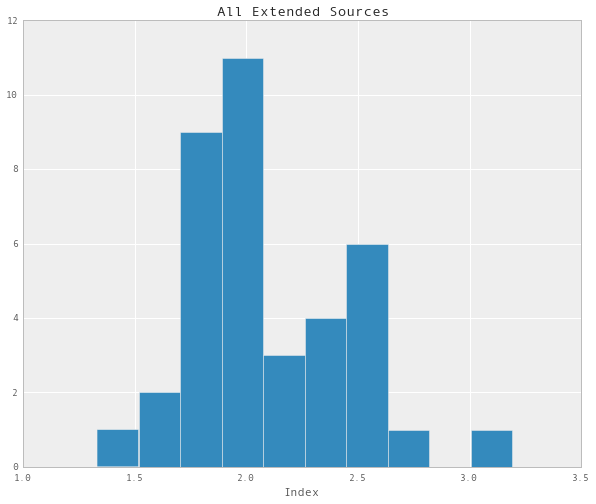

In [74]:
#Index for TS >= 25 ES
#I only need the next line the first time because index is list sometimes
#srcDF_pruned_ts25_ES.Index = srcDF_pruned_ts25_ES.Index.apply((lambda x: x[0])) #the x[0] is just because I might have a list and not just a value
srcDF_pruned_ts25_ES.hist('Index',figsize=[10,8])
plt.title('All Extended Sources')
plt.xlabel('Index')

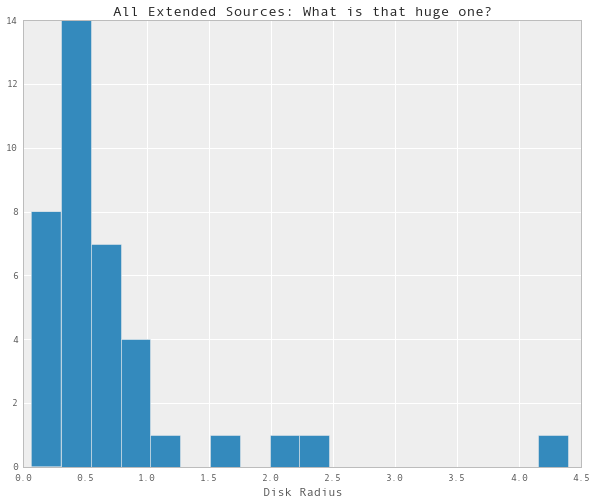

In [75]:
srcDF_pruned_ts25_ES.Sigma.dropna().apply((lambda x: x[0])).hist(bins  = 18,figsize=[10,8]) #do I know that the sigma I'm keeping is the best, should be if it's the last?
plt.title('All Extended Sources: What is that huge one?')
plt.xlabel('Disk Radius')
#plt.xlim(0,2.6)
#rebin this cause so many btwn 0-0.5
#srcDF_pruned.Sigma.dropna()

/Users/elunejava/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


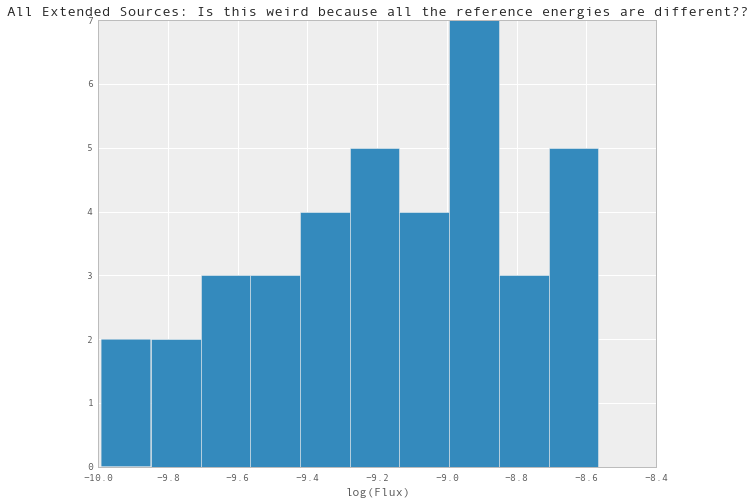

In [97]:
srcDF_pruned_ts25_ES.Flux# = srcDF_pruned.Flux.apply((lambda x: x[0])) 
#srcDF_pruned.hist(np.log10(srcDF_pruned.Flux))
srcDF_pruned_ts25_ES['log10Flux'] = srcDF_pruned.Flux.apply((lambda x: np.log10(x))) #makes a new col with log10 of the flux
srcDF_pruned_ts25_ES.log10Flux.hist(figsize=[10,8])
plt.title('All Extended Sources: Is this weird because all the reference energies are different??')
plt.xlabel('log(Flux)')

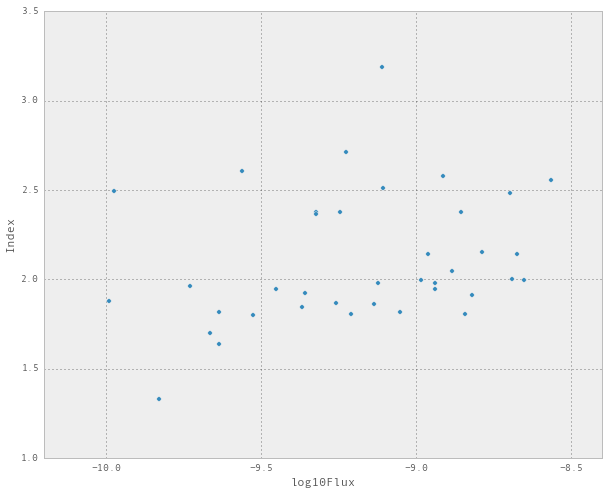

In [45]:
srcDF_pruned_ts25_ES.plot(kind = 'scatter',x = "log10Flux", y = 'Index',figsize=[10,8], figure = 1)
#scatter_matrix(srcDF_pruned_ts25_ES, alpha=0.2, figsize=(6, 6), diagonal='kde')
#srcDF_pruned.Flux.apply((lambda x: np.log10(x)))

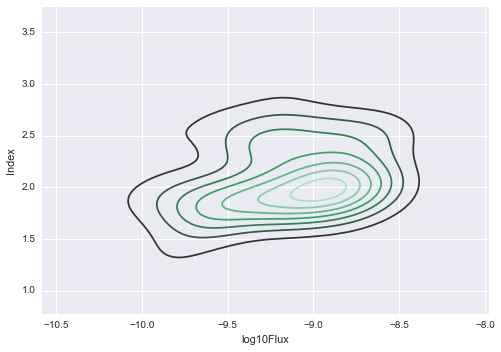

In [46]:
import seaborn as sns
sns.kdeplot(srcDF_pruned_ts25_ES.log10Flux, srcDF_pruned_ts25_ES.Index)

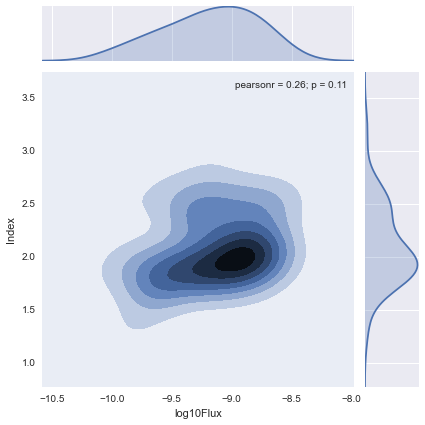

In [47]:
sns.jointplot(x="log10Flux", y="Index", data=srcDF_pruned_ts25_ES,kind = 'kde')

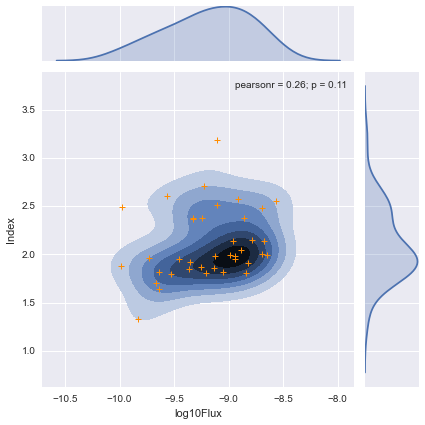

In [48]:
g = sns.jointplot(x="log10Flux", y="Index", data=srcDF_pruned_ts25_ES, kind = 'kde')
#g.plot_joint(x="log10Flux", y="Index", data=srcDF_pruned)
g.plot_joint(plt.scatter, s=30, linewidth=1, marker="+",color = 'DarkOrange')
g.ax_joint.collections[0].set_alpha(0)
#do this plot with energy flux insead?

In [89]:
srcDF_pruned_ts25_ES.srcType.unique()

array(['SNR', nan, 'UNK', 'COM', 'PWN', 'SNR?', 'PWN?'], dtype=object)

## Scatter plot/hist for flux/index, but with srcTypes highlighted

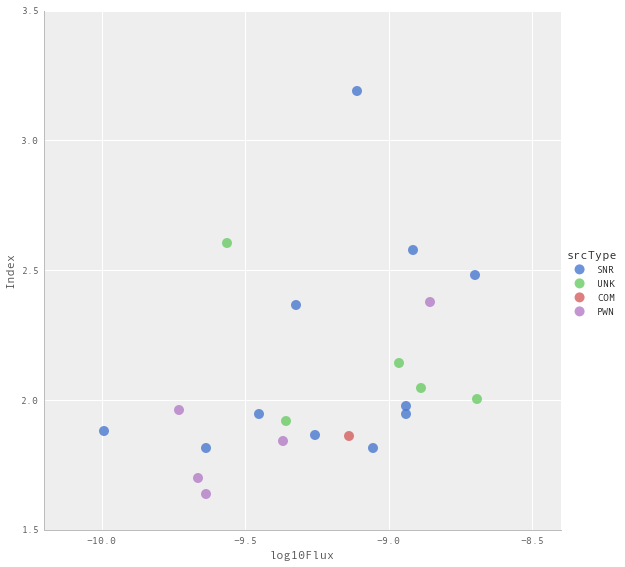

In [120]:
#not sure I need this, it's for plotting same y, 2 diff x axes with types side by side
#sns.pairplot(tips, x_vars=["total_bill", "size"], y_vars=["tip"],
#             hue="smoker", size=5, aspect=.8, kind="reg");

sns.lmplot(x="log10Flux", y="Index", hue="srcType", data=srcDF_pruned_ts25_ES, palette=sns.color_palette("muted"),fit_reg =False,size = 8,scatter_kws={"s": 100})
           #markers=["o", "x"], palette="Set1", fit_reg= False,figsize=[10,8]);
#sns.color_palette("husl", 8)
#sns.palplot(sns.color_palette("Set1", n_colors=8, desat=.5))
#sns.palplot(sns.color_palette("muted"))


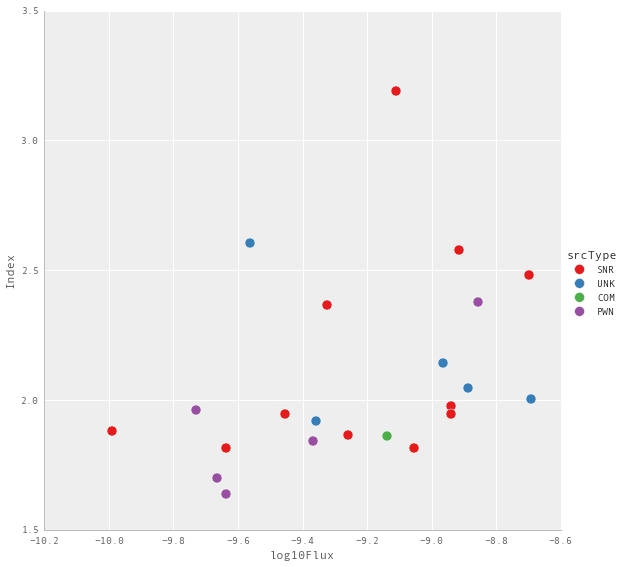

In [126]:
#IS this the same?
#g = sns.FacetGrid(rcDF_pruned_ts25_ES, hue="srcType", palette="Set1", size=5, hue_kws={"marker": ["^", "v"]})
g = sns.FacetGrid(srcDF_pruned_ts25_ES, hue="srcType", palette="Set1", size=8)
g.map(plt.scatter, "log10Flux", "Index", s=100, linewidth=.5, edgecolor="white")
g.add_legend();

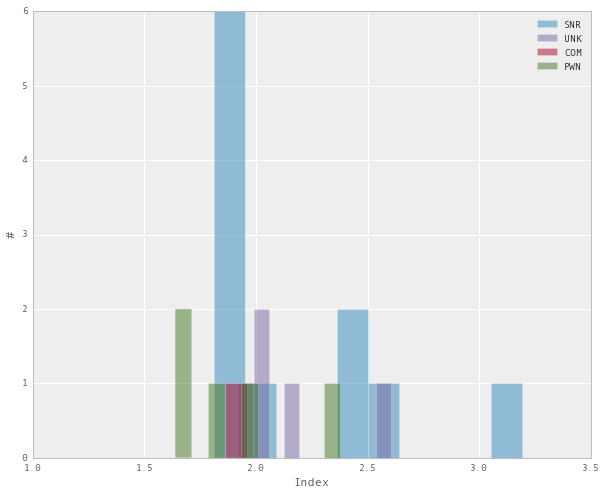

In [204]:
###If I had all indices as sep cols I think I could plot it easy, but that's strange, there's probably a way to groupby then plot right?
#still need to fix the binning

ax = srcDF_pruned_ts25_ES.Index[srcDF_pruned_ts25_ES.srcType =='SNR'].plot(kind='hist', alpha=0.5,label = 'SNR',figsize = [10,8])#,histtype = 'step')
srcDF_pruned_ts25_ES.Index[srcDF_pruned_ts25_ES.srcType =='UNK'].plot(kind='hist', alpha=0.5,ax =ax,label = 'UNK')
srcDF_pruned_ts25_ES.Index[srcDF_pruned_ts25_ES.srcType =='COM'].plot(kind='hist', alpha=0.5,ax =ax,label = 'COM')
srcDF_pruned_ts25_ES.Index[srcDF_pruned_ts25_ES.srcType =='PWN'].plot(kind='hist', alpha=0.5,ax =ax,label = 'PWN')
plt.legend(loc = 'best')
plt.xlabel('Index')
plt.ylabel('#')
#plt.savefig('/Users/jmcohen/Desktop/gt.png')

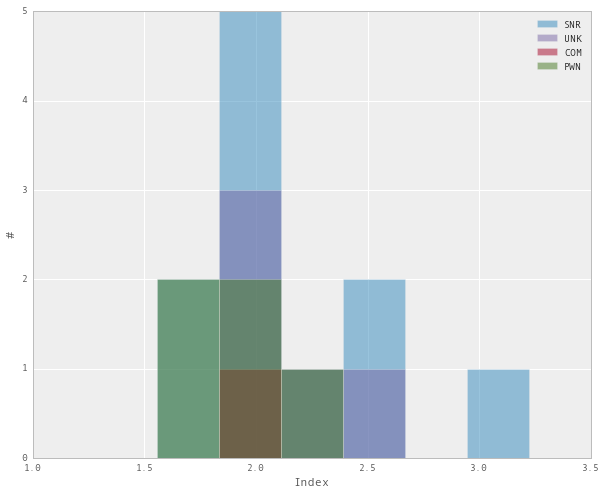

In [205]:
#same but try hist instead of plot to get bins right
bins = np.linspace(1,3.5,10)
ax = srcDF_pruned_ts25_ES.Index[srcDF_pruned_ts25_ES.srcType =='SNR'].hist(alpha=0.5,label = 'SNR',figsize = [10,8],bins  =bins)
srcDF_pruned_ts25_ES.Index[srcDF_pruned_ts25_ES.srcType =='UNK'].hist(alpha=0.5,ax =ax,label = 'UNK',bins = bins)
srcDF_pruned_ts25_ES.Index[srcDF_pruned_ts25_ES.srcType =='COM'].hist(alpha=0.5,ax =ax,label = 'COM',bins = bins)
srcDF_pruned_ts25_ES.Index[srcDF_pruned_ts25_ES.srcType =='PWN'].hist(alpha=0.5,ax =ax,label = 'PWN',bins = bins)
plt.legend(loc = 'best')
plt.xlabel('Index')
plt.ylabel('#')

#ax=srcDF_pruned_ts25_ES[srcDF_pruned_ts25_ES.srcType == 'SNR'].Index.hist(bins=bins)
#srcDF_pruned_ts25_ES[srcDF_pruned_ts25_ES.srcType == 'PWN'].Index.hist(ax=ax,bins =bins)

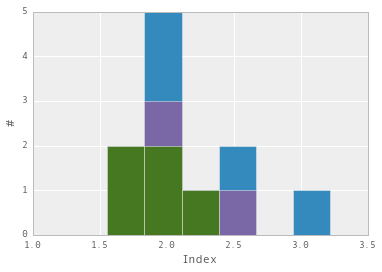

In [203]:
#Oooooo!
#why doesn't this show the the other 2?
#how to change colors? add labels
srcDF_pruned_ts25_ES.groupby('srcType',sort = False).Index.hist(alpha=0.4, bins = bins)
plt.legend(loc = 'best')
plt.xlabel('Index')
plt.ylabel('#')
plt.legend()

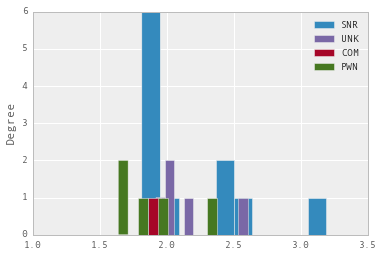

In [198]:
#idk why the bins are all different, or how to change the order. alpah not working is a bug I think
bins = np.linspace(1,3.5,10)
srcDF_pruned_ts25_ES.groupby('srcType',sort = False).Index.plot(kind="hist", alpha=0.5,bins = bins)
plt.legend()

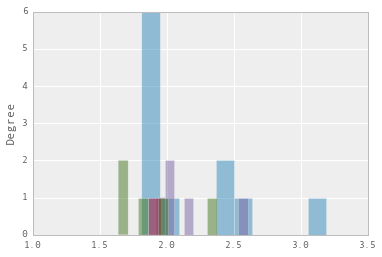

In [197]:
gr = srcDF_pruned_ts25_ES.groupby('srcType',sort = False).Index
for k, v in gr:
    v.plot(kind='hist', alpha=.5, label=k)

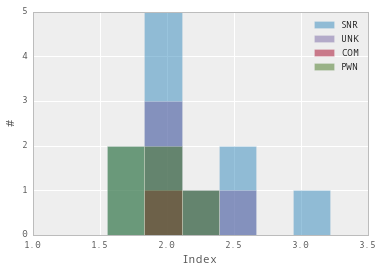

In [196]:
#how to change the order
gr = srcDF_pruned_ts25_ES.groupby('srcType',sort = False).Index
for k, v in gr:
    v.plot(kind='hist', alpha=.5, label=k,bins = bins)
plt.legend()
plt.xlabel('Index')
plt.ylabel('#')

# Try getting observed counts

In [ ]:
#get total observed counts in all RoI for comparing with 2FHL
#This is not really the total because the RoI are not unique
#Trye modeled instead
dropList = [s for s in resPan.minor_axis if not s.startswith('TotalObsCts')]
keepList = [s for s in resPan.minor_axis if s.startswith('TotalObsCts')]
paramList = ['Flux']
srcPan = resPan.ix[:, paramList,keepList]#.ix[:,:-3,:] #this only works be cause I know the order of the sources and because they're consecutive 

if 'ctsDF' in locals():
    del ctsDF
for f in srcPan.items:
    if not 'ctsDF' in locals():
        ctsDF = srcPan[f].transpose().dropna(how = 'all')
        #galDF.set_index(f)
    else:
        ctsDF = pd.concat([ctsDF,srcPan[f].transpose().dropna(how = 'all')])
        #galDF.set_index(f)        
ctsDF.set_index(srcPan.items,inplace = True) #I think this sets the index right
ctsDF.to_pickle('cts.dat')
ctsDF.columns = ['TotalObsCts']

In [ ]:
ctsDF.TotalObsCts.sum()

In [ ]:
#read in the 2FHL and 10gev cmap
cmap10 = pyfits.getdata("/Users/jmcohen/Desktop/allSky_10gev_74m_noRockCut_all_cmap.fits")
cmap50 = pyfits.getdata("/Users/jmcohen/Desktop/ft1-50GeV_p8_NOrockCut_allskyCmap.fits")

In [ ]:
print '50/10 gev counts', cmap10.sum()/float(cmap50.sum())
print '50 gev counts',cmap50.sum()
print '10 gev counts',cmap10.sum()

In [ ]:
#NOT SURE HOW TO MASK, don't worrk for now!
#If I wanted to try masking just in the plane, I would msk based on b <
import pyfits as pf
fitsImg = "/Users/jmcohen/Desktop/allSky_10gev_74m_noRockCut_all_cmap.fits"
Img = pf.open(fitsImg)
ImgData = Img[0].data
Img.close()
binsz = Img[0].header.get('CDELT2') #good for tsmaps, use b pixel size
#use pywcs to convert center, in GAL coords, to pixels
wcs = pywcs.WCS(Img[0].header)
centerPixels = wcs.wcs_sky2pix([[0,0]], 0).ravel()
#ImgData = np.ma.array(ImgData, mask = False)

In [ ]:
#GLATpixel = 
print wcs.wcs_pix2sky([[1800,1800]], 0).ravel()
print wcs.wcs_sky2pix([[359,0]], 0).ravel()
# print wcs.wcs_sky2pix([[90,10]], 0).ravel()
# print wcs.wcs_sky2pix([[0,-10]], 0).ravel()
# print wcs.wcs_sky2pix([[20,-10]], 0).ravel()
# print wcs.wcs_sky2pix([[180,10]], 0).ravel()

skyImg = wcs.all_pix2sky(np.asarray(ImgData),0)

In [ ]:
len(np.isnan(skyImg)[0])
#ImgData

In [ ]:
#Img[0].header

In [ ]:
for x,row in enumerate(ImgData):
    for y in enumerate(row):
        if (np.abs(wcs.wcs_pix2sky(x,y[0]).ravel()[0]) > 10):
        #if (distance(centerPixels[0],centerPixels[1],x,y[0]) <= pixelMinR) or (distance(centerPixels[0],centerPixels[1],x,y[0]) >= pixelMaxR):
            ImgData.mask[y[0]][x] = True

# Get diffuse


In [ ]:
#I want to make a single DF with all the ES/PS sources and (why not) all their source params (really just want postion, pos err, sigma, sigma  err)
#Do I want a single DF or keep as panel?
dropList = [s for s in resPan.minor_axis if not s.startswith('Galactic')]
keepList = [s for s in resPan.minor_axis if s.startswith('Galactic')]
paramList = ['Index','IndexError','ModCts','Norm','NormError']
srcPan = resPan.ix[:, paramList,keepList]#.ix[:,:-3,:] #this only works be cause I know the order of the sources and because they're consecutive 

if 'galDF' in locals():
    del galDF
for f in srcPan.items:
    if not 'galDF' in locals():
        galDF = srcPan[f].transpose().dropna(how = 'all')
        #galDF.set_index(f)
    else:
        galDF = pd.concat([galDF,srcPan[f].transpose().dropna(how = 'all')])
        #galDF.set_index(f)        
galDF.set_index(srcPan.items,inplace = True) #I think this sets the index right
galDF.to_pickle('galDiff.dat')
galDF['Norm'] = galDF.Norm.apply((lambda x: x[0])) ###all the values are lists, this makes them floats
galDF['numIndex'] = [float(i.strip('Region_l').replace('b','').split('_')[0]) for i in galDF.index] #can't think of a better way to sort string index naturally


In [ ]:
galDF.Norm

In [ ]:
os.chdir('/Users/jmcohen/Desktop/cur/gt10gevRuns/10gev/')
galDF.sort('numIndex').plot(y='Norm',kind = 'bar',fontsize=50,figsize = [60,20],figure = 1)
plt.ylabel('Galactic Normalization',fontsize = 65)
plt.axhline(galDF.Norm.mean(), lw = 4, ls = '--',color = 'DarkOrange',label = 'Mean = %.4s' %(galDF.Norm.mean()))
#plt.axhline(galDF.Norm.median(), lw = 3, ls = '--',color = 'maroon',label = 'Median')
plt.ylim(0,1.6)
plt.legend(loc='best', fontsize = 40)
plt.gcf().tight_layout()
plt.savefig('gt10gev_galNorms.png')

In [ ]:
print galDF.Norm.min(), galDF.Norm.max()

#Overlay all  10gev sources with sources of central RoI green and others in magenta

In [ ]:
mapsDir = os.path.join(galPlaneDir,'mapOverlays_neighbors')
if not os.path.exists(mapsDir) and not os.path.basename(os.getcwd()) == 'mapOverlays_neighbors': 
    os.mkdir(mapsDir)
os.chdir(mapsDir)
print os.getcwd()

In [ ]:
#added sqrt scale
singleReg = False
# allSrcs = '/Users/jmcohen/Desktop/cur/2FHLRuns/galPlane_lowNorm/2FHL_addSrcs_TSgt25.reg'
if singleReg:
    regFiles = [allSrcs]
else:
    regFiles = [os.path.join(os.path.dirname(regDir), 'TSgt16_gtlike.reg') for  regDir in regResDictsFin.values()] #all regions files as a list
for reg, regDir in regResDictsFin.items():
    print 'Working on %s' %(reg)
    galPlaneReg = os.path.join(os.path.dirname(regDir), 'TSgt16_gtlike.reg') #us the last .reg, but initial resid TS map
    regR = galPlaneReg
    if os.path.exists(regR): #for noGrad run, there are 2 missing reg files
        pyRegR = pyr.open(regR)
        for i in pyRegR: #make the sources in this specific region white
            i.attr[1]['color'] = 'white'
    for maps in ['Resdiual TS Map']:
        try:
            if maps == 'Resdiual TS Map':
                if os.path.exists(os.path.join(os.path.dirname(os.path.dirname(regDir)),'Initial_fit_' +reg+ '_tsmap.fits')):
                    mapPath = os.path.join(os.path.dirname(os.path.dirname(regDir)),'Initial_fit_' +reg+ '_tsmap.fits')
                else:
                    mapPath = os.path.join(os.path.dirname(os.path.dirname(regDir)),'Initial_fit_aftDelTSlt9_' +reg+ '_tsmap.fits')
                cbarTitle = 'TS'
            elif maps == 'Counts Maps':
                cmap = reg + '_cmap.fits'
                mapPath = os.path.join(galPlaneDir,reg,'10gevTo1000gev', cmap)
                cbarTitle = 'Counts'
        except Exception, e:
            print "%s for %s doesn't exist. Err: %s" %(maps,reg,str(e))
            continue
        if not os.path.exists(reg+maps.replace(' ','')+'Neighbors_addSrcsOverlay.png'):
            plt.clf()
            figTitle = reg + ' ' + maps
            f = aplpy.FITSFigure(mapPath)
            f.show_colorscale(vmin =0.0, pmax =100., cmap = 'hot', smooth = None, stretch = 'sqrt') #do I need to playt with the pmin/max? values?
            f.show_grid()
            f.tick_labels.set_xformat('ddd.dd')
            f.tick_labels.set_yformat('ddd.dd')
            f.frame.set_color('black')
            f.frame.set_linewidth(2)
            f.add_colorbar()
            f.axis_labels.set_font(size='large',weight='bold')
            f.tick_labels.set_font(weight = 'bold')
            f.add_label(0.5, 1.1, text = figTitle, relative = True, weight = 'medium', size='large')
            f.colorbar.set_axis_label_text(cbarTitle)
            f.colorbar.set_font(size='large',weight = 'bold')
            f.colorbar.set_axis_label_font(size='large',weight='bold')
            f.colorbar.set_ticks(ticks = plt.MaxNLocator(integer = True))
            center = reg.strip('Region_l').replace('b','').split('_') #b is always 0, but get it anyway in case I do runs with different b
            center = SkyCoord(l= float(center[0]), b = float(center[1]), frame = 'galactic', unit=(u.degree, u.degree))        
            for r in regFiles:
                if os.path.exists(r):
                    f.show_regions(r)
            if 'pyRegR' in locals():
                f.show_regions(pyRegR)
            sv = reg+maps.replace(' ','')+'Neighbors_addSrcsOverlay.png'
            f.save(sv)
            f.close()
            del f
        else:
            print '%s map already exists' %(reg)

# Overlay Mars sources with mine

In [ ]:
mapsDir = os.path.join(galPlaneDir,'mapOverlays_wMar')
if not os.path.exists(mapsDir) and not os.path.basename(os.getcwd()) == 'mapOverlays_wMar': 
    os.mkdir(mapsDir)
os.chdir(mapsDir)
print os.getcwd()

In [ ]:
#loop over the 2FHL dir with the fits files
#not sure how to get all the maps to show when doing them like this
#CHANGED THIS TO USE THE PRUNED FILE FOR 2FHL freeGalNorm
singleReg = True
allSrcs = '/Users/jmcohen/Desktop/cur/gt10gevRuns/10gev/gt10gev_pruned_TS25.reg'
zoom = False #2.5
pgwReg = '/Users/jmcohen/Desktop/cur/gt10gevRuns/10gev/finalregion3b_10gev_10000.0_3500000.0_filtered_090715.reg'
for reg, regDir in regResDictsFin.items():
    print 'Working on %s' %(reg)
    galPlaneReg = os.path.join(os.path.dirname(regDir), 'TSgt16.reg') #use the last .reg, but initial resid TS map
    if singleReg:
        regFiles = [pgwReg, allSrcs]
    else:
        regFiles = [pgwReg, galPlaneReg]
    for maps in ['Resdiual TS Map']:#,'Counts Maps']:
        try:
            if maps == 'Resdiual TS Map':
                if os.path.exists(os.path.join(os.path.dirname(os.path.dirname(regDir)),'Initial_fit_' +reg+ '_tsmap.fits')):
                    mapPath = os.path.join(os.path.dirname(os.path.dirname(regDir)),'Initial_fit_' +reg+ '_tsmap.fits')
                else:
                    mapPath = os.path.join(os.path.dirname(os.path.dirname(regDir)),'Initial_fit_aftDelTSlt9_' +reg+ '_tsmap.fits')
                cbarTitle = 'TS'
            elif maps == 'Counts Maps':
                cmap = reg + '_cmap.fits'
                mapPath = os.path.join(galPlaneDir,reg,'50gevTo3500gev', cmap)
                cbarTitle = 'Counts'
        except Exception, e:
            print "%s for %s doesn't exist. Err: %s" %(maps,reg,str(e))
            continue
        plt.clf()
        figTitle = reg + ' ' + maps
        f = aplpy.FITSFigure(mapPath)
        f.show_colorscale(vmin =0.0, pmax =100., cmap = 'hot', smooth = None,stretch = 'sqrt') #do I need to playt with the pmin/max? values?
        f.show_grid()
        f.tick_labels.set_xformat('ddd.dd')
        f.tick_labels.set_yformat('ddd.dd')
        f.frame.set_color('black')
        f.frame.set_linewidth(2)
        f.add_colorbar()
        f.axis_labels.set_font(size='large',weight='bold')
        f.tick_labels.set_font(weight = 'bold')
        f.add_label(0.5, 1.1, text = figTitle, relative = True, weight = 'medium', size='large')
        f.colorbar.set_axis_label_text(cbarTitle)
        f.colorbar.set_font(size='large',weight = 'bold')
        f.colorbar.set_axis_label_font(size='large',weight='bold')
        f.colorbar.set_ticks(ticks = plt.MaxNLocator(integer = True))
        for r in regFiles:
            if os.path.exists(r):
                f.show_regions(r)
            else: print "%s doesn't exist" %(r)
        for r in regFiles:
            if os.path.exists(r):
                f.show_regions(r)
            else: print "%s doesn't exist" %(r)
        for r in regFiles:
            if os.path.exists(r):
                f.show_regions(r)
            else: print "%s doesn't exist" %(r)
        if zoom:
            center = reg.strip('Region_l').replace('b','').split('_') #b is always 0, but get it anyway in case I do runs with different b
            center = SkyCoord(l= float(center[0]), b = float(center[1]), frame = 'galactic', unit=(u.degree, u.degree))
            f.recenter(center.l.degree, center.b.degree, zoom)
            sv = reg+maps.replace(' ','')+'_Mar_10gevOverlay_zoom.png'
            f.save(sv)
        else:
            sv = reg+maps.replace(' ','')+'_Mar_10gevOverlay.png'
            f.save(sv)
        f.close()
        del f

# Parse TeVCat file

In [ ]:
#i separated the names from params to make it easier to read in

tevcatNames = os.path(home,'Dropbox/CurrentWork/SNR_MC/tevSNRs/tevcatNames.txt')
tevcatParams = os.path(home,'Dropbox/CurrentWork/SNR_MC/tevSNRs/tevcatParams.txt')
tevNamesSer =  pd.Series.from_csv(tevcatNames,index_col=False, header=0)
#tevcatDF = pd.DataFrame.from_csv(tevcatParams,parse_dates=False,infer_datetime_format=False,na_values = ['----'])
tevcatDF = pd.read_csv(tevcatParams,parse_dates=False,infer_datetime_format=False,na_values = ['----'])
#tevcatDF.reset_index(inplace= True) #idk why it always tries to take RA is index, ooops this loses RA
tevcatDF.set_index(tevNamesSer,inplace = True)
#tevcatDF.index.name = 'TeVName'
tevcatDF.sort('TeV')
#rename radius col to Sigma
tevcatDF.rename(columns = {'Radius':'Sigma'},inplace = True)
#tevcatDF.index.str.rstrip()
#tevcatDF.rename(index=lambda x: x.rstrip())
tevcatDF

In [ ]:
outdir = "/Users/jmcohen/Desktop/tevcatDF.reg"
writeReg(tevcatDF,outdir)

In [ ]:
#TeV extended SNRs
len(tevcatDF[tevcatDF.Radius.notnull()]) #66 total extended!
#only 18 in SNR cat, how many are SNRs though
tevcatSNRS = tevcatDF[tevcatDF['TeV'].isin(['Shell','S-M', 'cSN','S-MC'])]
tevcatExtSNRs = tevcatSNRS[tevcatSNRS.Radius.notnull()]

#tevcatExt[tevcatExt['TeV'] == 'Shell' or tevcatExt['TeV'] == 'S-M' or tevcatExt['TeV'] == 'cSN']
tevcatSNRS

In [ ]:
#tevcatDF['GLON','GLAT'].apply(lambda ra,dec:  SkyCoord(ra=ra,dec=dec ,frame='icrs', unit = (u.hourangle,u.degree))
#tevcatDF['GLON']
#glat = SkyCoord(ra=tevcatDF.RA,dec=tevcatDF.Dec ,frame='icrs', unit = (u.hourangle,u.degree)).galactic

In [ ]:
# for i in glat:
#     print i.b.degree
# l,b = [crds.l.degree,crds.b.degree for crds in glat]

In [ ]:
# snr15 = SkyCoord(ra='18:18:04.8',dec='-15:28:01' ,frame='icrs', unit = (u.hourangle,u.degree))
# snr15.galactic

# Add Manitoba SNRs list, just names, get coords from the name. Can I get rad too?

In [ ]:
#Manitoba SNRs List. Just names, get coords from name
manSNRs= ['G000.0+00.0', 'G000.1-00.1', 'G000.3+00.0', 'G000.9+00.1', 'G001.0-00.1', 'G001.4-00.1', 'G001.9+00.3', 'G003.7-00.2', 'G003.8+00.3', 'G004.2-03.5', 'G004.5+06.8', 'G004.8+06.2', 'G005.2-02.6', 'G005.4-01.2', 'G005.5+00.3', 'G005.7-00.1', 'G005.9+03.1', 'G006.1+00.5', 'G006.1+01.2', 'G006.4+04.0', 'G006.4+04.9', 'G006.4-00.1', 'G006.5-00.4', 'G007.0-00.1', 'G007.2+00.2', 'G007.5-01.7', 'G007.7-03.7', 'G008.3-00.0', 'G008.7-00.1', 'G008.7-05.0', 'G008.9+00.4', 'G009.7-00.0', 'G009.8+00.6', 'G009.9-00.8', 'G010.5-00.0', 'G010.9-45.4', 'G011.0-00.0', 'G011.1+00.1', 'G011.1-00.7', 'G011.1-01.0', 'G011.2-00.3', 'G011.4-00.1', 'G011.8-00.2', 'G012.0-00.1', 'G012.2+00.3', 'G012.5+00.2', 'G012.7-00.0', 'G012.8-00.0', 'G013.3-01.3', 'G013.5+00.2', 'G014.1-00.1', 'G014.3+00.1', 'G015.1-01.6', 'G015.4+00.1', 'G015.9+00.2', 'G016.0-00.5', 'G016.2-02.7', 'G016.4-00.5', 'G016.7+00.1', 'G017.0-00.0', 'G017.4-00.1', 'G017.4-02.3', 'G017.8-02.6', 'G018.0-00.7', 'G018.1-00.1', 'G018.5-00.4', 'G018.6-00.2', 'G018.8+00.3', 'G018.9-01.1', 'G019.1+00.2', 'G020.0-00.2', 'G020.4+00.1', 'G021.0-00.4', 'G021.5-00.1', 'G021.5-00.9', 'G021.6-00.8', 'G021.8-00.6', 'G021.9-00.1', 'G022.7-00.2', 'G023.3-00.3', 'G023.5+00.1', 'G023.6+00.3', 'G024.7+00.6', 'G024.7-00.6', 'G025.1-02.3', 'G025.2+00.3', 'G026.6-00.1', 'G027.4+00.0', 'G027.8+00.6', 'G028.6-00.1', 'G028.8+01.5', 'G029.4+00.1', 'G029.6+00.1', 'G029.7-00.3', 'G030.7+01.0', 'G030.7-02.0', 'G031.5-00.6', 'G031.9+00.0', 'G032.0-04.9', 'G032.1-00.9', 'G032.4+00.1', 'G032.6+00.5', 'G032.8-00.1', 'G033.2-00.6', 'G033.6+00.1', 'G034.0+20.3', 'G034.7-00.4', 'G035.6-00.4', 'G036.0+00.1', 'G036.6+02.6', 'G036.6-00.7', 'G038.7-01.3', 'G039.2-00.3', 'G039.7-02.0', 'G040.5-00.5', 'G041.1-00.3', 'G041.5+00.4', 'G042.0-00.1', 'G042.8+00.6', 'G043.3-00.2', 'G043.9+01.6', 'G044.5-00.2', 'G045.7-00.4', 'G046.8-00.3', 'G047.4-03.9', 'G049.2-00.7', 'G053.6-02.2', 'G054.1+00.3', 'G054.4-00.3', 'G055.0+00.3', 'G055.7+03.4', 'G057.2+00.8', 'G059.2-04.7', 'G059.5+00.1', 'G059.8+01.2', 'G063.7+01.1', 'G064.5+00.9', 'G065.1+00.6', 'G065.3+05.7', 'G065.7+01.2', 'G065.8-00.5', 'G066.0-00.0', 'G067.6+00.9', 'G067.7+01.8', 'G067.8+00.5', 'G068.6-01.2', 'G069.0+02.7', 'G069.7+01.0', 'G073.9+00.9', 'G074.0-08.5', 'G074.9+01.2', 'G075.2+00.1', 'G076.9+01.0', 'G078.2+02.1', 'G080.2+01.0', 'G082.2+05.3', 'G083.0-00.3', 'G084.2-00.8', 'G085.4+00.7', 'G085.9-00.6', 'G089.0+04.7', 'G093.3+06.9', 'G093.7-00.2', 'G094.0+01.0', 'G096.0+02.0', 'G106.3+02.7', 'G107.5-01.5', 'G108.2-00.6', 'G108.5+11.0', 'G108.6+06.8', 'G109.1-01.0', 'G111.7-02.1', 'G113.0+00.2', 'G114.3+00.3', 'G116.5+01.1', 'G116.9+00.2', 'G119.5+10.2', 'G120.1+01.4', 'G126.2+01.6', 'G127.1+00.5', 'G128.5+02.6', 'G130.7+03.1', 'G132.7+01.3', 'G141.2+05.0', 'G148.1+00.8', 'G149.5+03.2', 'G150.3+04.5', 'G150.8+03.8', 'G151.2+02.9', 'G152.4-02.1', 'G156.2+05.7', 'G159.6+07.3', 'G160.1-01.1', 'G160.9+02.6', 'G162.8-16.0', 'G166.0+04.3', 'G172.8+01.5', 'G178.2-04.2', 'G179.0+02.6', 'G180.0-01.7', 'G182.4+04.3', 'G184.6-05.8', 'G189.1+03.0', 'G189.6+03.3', 'G190.2+01.1', 'G190.9-02.2', 'G192.8-01.1', 'G195.1+04.3', 'G205.5+00.5', 'G206.9+02.3', 'G213.0-00.6', 'G230.4-01.4', 'G260.4-03.4', 'G261.9+05.5', 'G263.9-03.3', 'G266.2-01.2', 'G267.0-01.0', 'G269.7+00.0', 'G272.2-03.2', 'G276.5+19.0', 'G279.0+01.1', 'G284.0-01.8', 'G284.2-00.4', 'G284.3-01.8', 'G285.1-00.5', 'G286.5-01.2', 'G287.4+00.6', 'G289.7-00.3', 'G290.1-00.8', 'G291.0+00.1', 'G291.0-00.1', 'G292.0+01.8', 'G292.2-00.5', 'G293.8+00.6', 'G294.1-00.0', 'G296.1-00.5', 'G296.5+10.0', 'G296.6-00.4', 'G296.7-00.9', 'G296.8-00.3', 'G298.5-00.3', 'G298.6-00.0', 'G299.2-02.9', 'G299.3-01.5', 'G299.6-00.5', 'G301.4-01.0', 'G302.3+00.7', 'G304.1-00.2', 'G304.6+00.1', 'G306.3-00.9', 'G308.1-00.7', 'G308.4-01.4', 'G308.8-00.1', 'G309.2-00.6', 'G309.8+00.0', 'G309.8-02.6', 'G310.6-00.3', 'G310.6-01.6', 'G310.7-05.4', 'G310.8-00.4', 'G310.9-00.3', 'G311.5-00.3', 'G312.4-00.4', 'G312.5-03.0', 'G313.3+00.1', 'G313.6+00.3', 'G315.1+02.7', 'G315.4-00.3', 'G315.4-02.3', 'G315.9-00.0', 'G316.3-00.0', 'G317.3-00.2', 'G317.9-01.8', 'G318.2+00.1', 'G318.9+00.4', 'G319.9-00.7', 'G320.4-01.2', 'G320.6-01.6', 'G321.3-03.9', 'G321.9-00.3', 'G321.9-01.1', 'G322.1+00.0', 'G322.5-00.1', 'G322.7+00.1', 'G322.9-00.0', 'G323.5+00.1', 'G323.7-01.0', 'G323.9+00.0', 'G324.1+00.0', 'G325.0-00.3', 'G326.3-01.8', 'G327.1-01.1', 'G327.2-00.1', 'G327.4+00.4', 'G327.4+01.0', 'G327.6+14.6', 'G328.4+00.2', 'G329.7+00.4', 'G330.0+15.0', 'G330.2+01.0', 'G330.7+00.1', 'G332.0+00.2', 'G332.4+00.1', 'G332.4-00.4', 'G332.5-00.3', 'G332.5-05.6', 'G333.9+00.0', 'G334.0-00.8', 'G335.2+00.1', 'G336.4+00.2', 'G336.7+00.5', 'G336.7-00.3', 'G336.9-00.5', 'G337.0-00.1', 'G337.2+00.1', 'G337.2-00.7', 'G337.3+01.0', 'G337.5-00.1', 'G337.8-00.1', 'G338.1+00.4', 'G338.3-00.0', 'G338.5+00.1', 'G340.4+00.4', 'G340.6+00.3', 'G341.2+00.9', 'G341.9-00.3', 'G342.0-00.2', 'G342.1+00.9', 'G343.0-06.0', 'G343.1-00.7', 'G343.1-02.3', 'G344.7+00.1', 'G344.7-00.1', 'G345.1-00.2', 'G345.2+00.2', 'G345.7-00.2', 'G346.2-01.0', 'G346.6-00.2', 'G347.3-00.5', 'G348.5+00.1', 'G348.5-00.0', 'G348.7+00.3', 'G348.9+01.1', 'G348.9-00.4', 'G349.2-00.1', 'G349.7+00.2', 'G350.0-02.0', 'G350.1-00.3', 'G350.2-00.8', 'G351.0-05.4', 'G351.2+00.1', 'G351.7+00.8', 'G351.9-00.9', 'G352.7-00.1', 'G353.6-00.7', 'G353.9-02.0', 'G354.1+00.1', 'G354.1+00.3', 'G354.4+00.0', 'G354.8-00.8', 'G355.4+00.7', 'G355.6-00.0', 'G355.9-02.5', 'G356.2+04.5', 'G356.3-00.3', 'G356.3-01.5', 'G357.7+00.3', 'G357.7-00.1', 'G358.0+03.8', 'G358.1+00.1', 'G358.3+00.2', 'G358.5-00.9', 'G358.6-01.0', 'G359.0-00.9', 'G359.1+00.9', 'G359.1-00.5', 'G359.2-00.8', 'G359.9-00.0']
 

In [ ]:
crdsMan = [[float(i.strip('G')[:5]),float(i.strip('G')[5:])]  for i in manSNRs]
l,b = zip(*crdsMan)
crdsManDict = dict(zip(manSNRs,crdsMan))
manSNRsDF = pd.DataFrame.from_dict(orient ='index', data = crdsManDict)
manSNRsDF.columns=['l','b']
manSNRsDF

In [ ]:
manReg = "/Users/jmcohen/Desktop/manSNRs.reg"
writeReg(manSNRsDF,manReg)

# Read in Green's Cat

In [ ]:
greensCat = "/Users/jmcohen/Desktop/cur/gt10gevRuns/10gev/greensCat.txt"
greensDF = pd.read_csv(greensCat,header = 0,index_col = 0, na_values=[' ','  ','   ','    ','     '])#DataFrame.from_csv(greensCat)

In [ ]:
greensDF

# Read in 2FHL

In [ ]:
pg = pyfits.open('/Users/jmcohen/Dropbox/CurrentWork/2FHL/2FHL_catalog_v5.21.fits')
pgd = pg[1].data
pgdExt = pg[2].data
#get an error just trying to read the pyfits object into pandas
#convert to dict of lists and then read that in

#This is for the 2FHL_catalog_v0.fits version of the catalog
pgdict = {x:pgd.field(x) for x in pgd.names}
for i in pgdict:
    #if pgdict.get(i).dtype is 'S10':
    pgdict[i] = list(pgdict.get(i))
        
pgw = pd.DataFrame(pgdict)
pgw.set_index('Source_Name',inplace = True)
#pgwdExt
pgdictExt = {x:pgdExt.field(x) for x in pgdExt.names}
for i in pgdictExt:
    #if pgdict.get(i).dtype is 'S10':
    pgdictExt[i] = list(pgdictExt.get(i))
        
pgwExt = pd.DataFrame(pgdictExt)
pgwExt.set_index('Source_Name',inplace = True)

# pgw.columns
# pgwExt.columns

In [ ]:
pgw

In [ ]:
os.chdir('/Users/jmcohen/Desktop/')
writeReg(pgw,'2FHL_catalog_v5.21.reg') #makes circles now?

# Read in 3FGL

In [ ]:
#Read in 3FGL to DataFrame
#removes the uncertainties for nowsince the are 2D
#should just add a dict for upper and lower

#if I just want extended read in the extended extension (next cell)
fgl3 = pyfits.open('/Users/jmcohen/Dropbox/Catalogs/3FGL/gll_psc_v14.fit')
fgl3d =  fgl3[1].data
poplist = []
fgl3dict = {x:fgl3d.field(x) for x in fgl3d.names}
for i in fgl3dict:
    fgl3dict[i] = list(fgl3dict.get(i))
#     if fgl3dict.get(i).ndim > 1:
#         poplist.append(i)

# for i in poplist:
#     fgl3dict.pop(i)
fgl3DF = pd.DataFrame(fgl3dict)
fgl3DF.set_index('Source_Name',inplace = True)
ext3FGL = [i for i in fgl3DF.index if i.endswith('e')]
ext3FGLDF = fgl3DF.loc[ext3FGL]
#ext3FGLDF.Extended_Source_Name

In [ ]:
fgl3DF

# Read in Mars 10gev results

In [ ]:
mars= "/Users/jmcohen/Desktop/cur/gt10gevRuns/10gev/finalsrcsinroi3b_10gev_10000.0_3500000.0_filtered__090715.dat"
#marsDF = pd.read_csv(mars,sep = ',')
marsDF = pd.DataFrame.from_csv(mars, sep = ',')
marsDF.set_index('srcName',inplace = True)
# marsDFTSgt25 = dfMar[dfMar.TS >= 25]
# marsDFTSgt25

In [ ]:
marsDF

# Nearest neighor for 10gev with each other cat

Be aware of which 3FGL/2FHL/TeV sources use sigma Gauss to measure extent and not disk sigma
This will take a day, don't do this now!

In [ ]:
#Mar
crdsMar = SkyCoord(l = marsDF.ra ,b = marsDF.dec, frame = 'fk5', unit = (u.degree, u.degree))
if 'marNearDF' in locals():
    del marNearDF
marNearDF = pd.DataFrame(columns=['NearestNeighbor', 'AngSep', 'Primary_l', 'NN_l', 'Primary_b','NN_b'])#,'Primary_Sigma','NN_Sigma']) #include sigma just to make it easy to cut out ES
indMin, indSep, sep = chkSep(crds2FHL_PS, crds2FHL_PS,n = 2) # idk if I need indMin?
for i,j in enumerate(indSep): #i is index of crdsAdd with nearest 3FGL ES, that has index j #use indMin or indSep
    srci = df2FHL.iloc[i]
    srcj = df2FHL.iloc[j]
    dfnearPGW.loc[srci.name] = [srcj.name,sep[i].degree, srci.GLON, srcj.GLON, srci.GLAT, srcj.GLAT,srci.Spectral_Index, srcj.Spectral_Index]#,sigi,sigj]

In [ ]:
#2FHL

In [ ]:
#3FGL

In [ ]:
#TeVCat

In [ ]:
#manitoba/greens

# Maps of all regions

## SImilar to the maps I made for 2FHL paper, not sure I can do these as easily for all here since I added specifc details for each SNR

### don't show any labels for sources?
### make another region file where I remove all the labels
### Since we're only look at the regions where we agree, I'll make some maps

In [4]:
mapsDir = os.path.join(galPlaneDir,'AAS2016')
if not os.path.exists(mapsDir) and not os.path.basename(os.getcwd()) == 'AAS2016': 
    os.mkdir(mapsDir)
os.chdir(mapsDir)
print os.getcwd()

/Users/elunejava/Desktop/gt10gev/fixedLLthresh_freeDiff/AAS2016


In [ ]:
###Zoom in of the 6 2FHL sources, fix axis labels to be larger
###don't for all sources in RoI, could do for all ES though?
#albSrc = {'l145_b0_ES_1':'Region_l150.0_b0.0', 'l290_b0_ES_1':'Region_l290.0_b0.0', 'l315_b0_ES_3':'Region_l315.0_b0.0', 'l30_b0_ES_2':'Region_l25.0_b0.0', 'l315_b0_ES_4':'Region_l315.0_b0.0', 'l315_b0_ES_1':'Region_l315.0_b0.0'}
albSrc = {'l145_b0_ES_1':'Region_l150.0_b0.0'}
srcFromReg = {'l145_b0_ES_1':'Region_l145.0_b0.0', 'l290_b0_ES_1':'Region_l290.0_b0.0', 'l315_b0_ES_3':'Region_l315.0_b0.0', 'l30_b0_ES_2':'Region_l30.0_b0.0', 'l315_b0_ES_4':'Region_l315.0_b0.0', 'l315_b0_ES_1':'Region_l315.0_b0.0'}
#I want to have different params for vmax and zoom for each source
#make two dicts with the params to enter by hand
vmaxD = {'l145_b0_ES_1':30,'l290_b0_ES_1':40, 'l315_b0_ES_3':55, 'l30_b0_ES_2':40, 'l315_b0_ES_4':65, 'l315_b0_ES_1':45}
zoomD = {'l145_b0_ES_1':3, 'l290_b0_ES_1':2.5, 'l315_b0_ES_3':2, 'l30_b0_ES_2':1.5, 'l315_b0_ES_4':2, 'l315_b0_ES_1':2}
#zoom = 3.0
plt.clf()
singleReg = True
pgwES = '/Users/jmcohen/Desktop/cur/2FHLRuns/galPlane_lowNorm/2FHL_addSrcs_TSgt25_justES.reg' # cur/2FHLRuns/galPlane_lowNorm/2FHL_addSrcs_TSgt25_justES_2FHL_noLab.reg'
#pgw = '/Users/jmcohen/Dropbox/CurrentWork/2FHL/2FHL_v2.3_noLab.reg'
pgw = '/Users/jmcohen/Dropbox/CurrentWork/2FHL/2FHL_catalog_v4.0.reg_noLab.reg' #used for G150
#regFiles = [pgwES,pgw]
regFiles = [pgw] #addSrcs ES are included in the 2FHL reg
for srcReg,reg in albSrc.items():
    regDir = regResDictsFin.get(reg)
#     if not reg in 'Region_l290.0_b0.0':#'Region_l150.0_b0.0': #reg in ['Region_l315.0_b0.0','Region_l150.0_b0.0','Region_l25.0_b0.0','Region_l290.0_b0.0']:
#         continue
    print 'Working on %s' %(srcReg)
    for maps in ['Resdiual TS Map']:
        try:
            if maps == 'Resdiual TS Map':
                mapPath = os.path.join(os.path.dirname(os.path.dirname(regDir)),'Initial_fit_' +reg+ '_tsmap.fits')
                cbarTitle = 'TS'
            elif maps == 'Counts Maps':
                cmap = reg + '_cmap.fits'
                mapPath = os.path.join(galPlaneDir,reg,'50gevTo3500gev', cmap)
                cbarTitle = 'Counts'
        except Exception, e:
            print "%s for %s doesn't exist. Err: %s" %(maps,reg,str(e))
            continue
        f = aplpy.FITSFigure(mapPath)
        f.show_colorscale(vmin = 0, vmax =vmaxD.get(srcReg),cmap = 'hot', smooth = None,) #do I need to playt with the pmin/max? values?
        f.set_tick_color('white')
        f.show_grid()
        f.add_label(x = 150.4,y=3.3,text = '2FHL J0431.2+5553e',family = 'Helvetica', relative =False, weight = 2, size =28, color = 'cyan')
        f.add_label
        f.set_system_latex(usetex = False)
        # f.set_tick_labels_style('latex')
        # f.set_labels_latex(True)
        f.tick_labels.set_xformat('ddd.dd')
        f.tick_labels.set_yformat('ddd.dd')
        ax = plt.gca()
        ax.xaxis.label.set_color('k')
        ax.yaxis.label.set_color('k')
        [i.set_color("k") for i in plt.gca().get_xticklabels()]
        [i.set_color("k") for i in plt.gca().get_yticklabels()]
        cbar = plt.colorbar
        f.frame.set_color('black')
        f.frame.set_linewidth(2)
        f.add_colorbar()
        f.axis_labels.set_font(size='28',weight='bold')
        f.tick_labels.set_font(size ='20',weight = 'bold')
        f.colorbar.set_axis_label_text(cbarTitle)
        ###
        c = f.image.colorbar
        c.ax.yaxis.label.set_color('k')
        [i.set_color("k") for i in c.ax.get_yticklabels()]
        #color_bar = plt.colorbar(f.image.colorbar())                            #this one is a little bit
        #cbytick_obj = plt.getp(color_bar.ax.axes, 'yticklabels')                #tricky
        #plt.setp(cbytick_obj, color='r')
        ###
        #c.set_tick_color('k')
        #f.colorbar.set_color
        f.colorbar.set_font(size='20',weight = 'bold')
        f.colorbar.set_axis_label_font(size='28',weight='bold')
        #f.colorbar.solids.set_edgecolor("face") #not sure this works?
        #f.colorbar.set_ticks(ticks = plt.MaxNLocator(integer = True))
        #Region_l150.0_b0.0 l145_b0_ES_1
        #resPan['Region_l30.0_b0.0'].transpose().dropna(how = 'all').loc['l30_b0_ES_2']
        reg = srcFromReg.get(srcReg)
        l = resPan[reg].transpose().dropna(how = 'all').loc[srcReg].l
        if srcReg in 'l315_b0_ES_1':
            l = l + 0.5
        b = resPan[reg].transpose().dropna(how = 'all').loc[srcReg].b
        if srcReg in 'l145_b0_ES_1':
            b = b-1.5
        f.recenter(l, b, zoomD.get(srcReg))
        for r in regFiles:
            f.show_regions(r)
#         for r in regFiles:
#             f.show_regions(r)
#         for r in regFiles:
#             f.show_regions(r)
        #break
        #f.show_regions(allSrcs)
        # f.add_grid()
        # f.hide_grid()
        # aplpy.grid.Grid(f).hide()
        #break
        sv = srcReg+maps.replace(' ','')+'_residTSmap_2FHL_zoom.eps'
        f.save(sv)
        #sv = srcReg+maps.replace(' ','')+'_residTSmap_2FHL_zoom.png'
        #f.save(sv)
        f.close()
        del f
    #break

# sigma 10gev vs. GeV vs. TeV vs. radio
## to do this , I need to add cols to the DF assinging a TeV/oldGeV/radio name to each ES
## I don't want to do this until more runs have finished though?
## or maybe I just have to use the all runs rois and not final.dat?

# For Fermi symp 15 poster and AAS winter 2016 
### No lables for now

In [7]:
###Zoom in of the 6 2FHL sources, fix axis labels to be larger
###don't for all sources in RoI, could do for all ES though?
zoom = 1.4
albSrc = {'l315_b0_ES_6':'Region_l315.0_b0.0','l150_b0_ES_1':'Region_l150.0_b0.0','l315_b0_ES_1':'Region_l315.0_b0.0','l110_b0_ES_1':'Region_l110.0_b0.0'}
srcFromReg = {'l315_b0_ES_6':'Region_l315.0_b0.0','l150_b0_ES_1':'Region_l150.0_b0.0','l315_b0_ES_1':'Region_l315.0_b0.0','l110_b0_ES_1':'Region_l110.0_b0.0'}
#I want to have different params for vmax and zoom for each source
#make two dicts with the params to enter by hand
vmaxD = {'l315_b0_ES_6':54,'l150_b0_ES_1':35,'l315_b0_ES_1':43,'l110_b0_ES_1':25}#,'l290_b0_ES_1':40, 'l315_b0_ES_3':55, 'l30_b0_ES_2':40, 'l315_b0_ES_4':65, 'l315_b0_ES_1':45}
zoomD = {'l315_b0_ES_6':3,'l150_b0_ES_1':3,'l315_b0_ES_1':2,'l110_b0_ES_1':2}# 'l290_b0_ES_1':2.5, 'l315_b0_ES_3':2, 'l30_b0_ES_2':1.5, 'l315_b0_ES_4':2, 'l315_b0_ES_1':2}
vmaxCmap  = {'l315_b0_ES_6':8,'l150_b0_ES_1':1.3,'l315_b0_ES_1':2.4,'l110_b0_ES_1':2}#,'l290_b0_ES_1':40, 'l315_b0_ES_3':55, 'l30_b0_ES_2':40, 'l315_b0_ES_4':65, 'l315_b0_ES_1':45}
#zoom = 3.0
reg3fgl = "/Users/elunejava/Dropbox/Catalogs/3FGL/gll_psc_v15_noLab.reg"
plt.clf()
singleReg = True
#cont = "/Users/elunejava/Desktop/G150_radioMaps/G150.3+4.5_WENSS_radio325MHz.fits"
#pgwES = '/Users/jmcohen/Desktop/cur/2FHLRuns/galPlane_lowNorm/2FHL_addSrcs_TSgt25_justES.reg' # cur/2FHLRuns/galPlane_lowNorm/2FHL_addSrcs_TSgt25_justES_2FHL_noLab.reg'
#pgw = '/Users/jmcohen/Dropbox/CurrentWork/2FHL/2FHL_v2.3_noLab.reg'
pgw = os.path.join(home,"/Users/elunejava/Desktop/gt10gev/gt10gev_pruned_TS25_nolab.reg") #used for G150
#Try marianne's region file
mar = os.path.join(home,"/Users/elunejava/Desktop/finalregion4_revised2_10gev_10000.0_3500000.0_pruned_noLab_myPSRs.reg") 
#regFiles = [pgwES,pgw]
regFiles = [mar]#[pgw,mar] #addSrcs ES are included in the 2FHL reg
for srcReg,reg in albSrc.items():
    if not srcReg.startswith('l315_b0_ES_6'): continue
    regDir = regResDictsAll.get(reg)
    #print srcReg, reg,regDir
    #print os.path.dirname(os.path.dirname(regDir)),'Initial_fit_aftDelTSlt9_' +reg+ '_tsmap.fits'
#     if not reg in 'Region_l290.0_b0.0':#'Region_l150.0_b0.0': #reg in ['Region_l315.0_b0.0','Region_l150.0_b0.0','Region_l25.0_b0.0','Region_l290.0_b0.0']:
#         continue
    print 'Working on %s' %(srcReg)
    for maps in ['Resdiual TS Map','Counts Maps']:
        try:
            if maps == 'Resdiual TS Map':
                #because I have them already
                mapPath = os.path.join(os.path.dirname(os.path.dirname(regDir)),'Initial_fit_aftDelTSlt9_' +reg+ '_tsmap.fits')
                #mapPath = '/Users/elunejava/Desktop/gt10gev/free_galInd_iso/fixedAddSrcsprobs/Region_l150.0_b0.0/10gevTo1000gev/addSrcs/ES_4_Region_l150.0_b0.0_zero_tsmap.fits'###hacked map math
                #mapPath = '/Users/elunejava/Desktop/l315zeroMaps/ES_8_zero_tsmap.fits'
                cbarTitle = 'TS'
                #continue
            elif maps == 'Counts Maps':
                #cmap = reg + '_cmap_big.fits' #'Region_l315.0_b0.0_cmap.fits'
                cmap = reg + '_cmap.fits' #'Region_l315.0_b0.0_cmap.fits'
                mapPath = os.path.join(galPlaneDir,reg,'10gevTo1000gev', cmap)
                #mapPath = "/Users/elunejava/Desktop/Regionl150.0_b0_cmap_big.fits"#os.path.join(galPlaneDir,reg,'10gevTo1000gev', cmap)
                cbarTitle = 'Counts'
                continue
        except Exception, e:
            print "%s for %s doesn't exist. Err: %s" %(maps,reg,str(e))
            continue
        f = aplpy.FITSFigure(mapPath)
        if maps == 'Counts Maps':
            f.show_colorscale(vmin = 0, vmax =vmaxCmap.get(srcReg),cmap = 'gray', smooth = 3) #do I need to playt with the pmin/max? values?
        else:
            f.show_colorscale(vmin = 0, vmax =vmaxD.get(srcReg),cmap = 'hot', smooth = None,) #do I need to playt with the pmin/max? values?
        f.set_tick_color('white')
        f.show_grid()
        #f.add_label(x = 150.4,y=3.3,text = 'G150.3+4.5',family = 'Helvetica', relative =False, weight = 2, size =28, color = 'cyan')
        f.add_label
        f.set_system_latex(usetex = False)
        # f.set_tick_labels_style('latex')
        # f.set_labels_latex(True)
        f.tick_labels.set_xformat('ddd.dd')
        f.tick_labels.set_yformat('ddd.dd')
        ax = plt.gca()
        ax.xaxis.label.set_color('k')
        ax.yaxis.label.set_color('k')
        [i.set_color("k") for i in plt.gca().get_xticklabels()]
        [i.set_color("k") for i in plt.gca().get_yticklabels()]
        cbar = plt.colorbar
        f.frame.set_color('black')
        f.frame.set_linewidth(2)
        f.add_colorbar()
        f.axis_labels.set_font(size='28',weight='bold')
        f.tick_labels.set_font(size ='20',weight = 'bold')
        f.colorbar.set_axis_label_text(cbarTitle)
        ###
        c = f.image.colorbar
        c.ax.yaxis.label.set_color('k')
        [i.set_color("k") for i in c.ax.get_yticklabels()]
        #color_bar = plt.colorbar(f.image.colorbar())                            #this one is a little bit
        #cbytick_obj = plt.getp(color_bar.ax.axes, 'yticklabels')                #tricky
        #plt.setp(cbytick_obj, color='r')
        ###
        #c.set_tick_color('k')
        #f.colorbar.set_color
        f.colorbar.set_font(size='20',weight = 'bold')
        f.colorbar.set_axis_label_font(size='28',weight='bold')
        #f.colorbar.solids.set_edgecolor("face") #not sure this works?
        #f.colorbar.set_ticks(ticks = plt.MaxNLocator(integer = True))
        #Region_l150.0_b0.0 l145_b0_ES_1
        #resPan['Region_l30.0_b0.0'].transpose().dropna(how = 'all').loc['l30_b0_ES_2']
        reg = srcFromReg.get(srcReg)
        if 'l315_b0_ES_6' in srcReg:
            l = 313.57476
            b = 0.24214198
        else:
            l = resPan[reg].transpose().dropna(how = 'all').loc[srcReg].l
            #if srcReg in 'l315_b0_ES_1':
            #    l = l + 0.5
            b = resPan[reg].transpose().dropna(how = 'all').loc[srcReg].b
        if srcReg in 'l150_b0_ES_1':
            pass
            l=150.3
            b = 4.5#b-1. #150.2419 	4.579911
            #f.show_contour(cont, convention='wells', overlap = True, returnlevels = False, colors = 'saddlebrown',levels = [0.0001,0.636425,0.9], filled = False, smooth = 3,lw = 6)
        f.recenter(l, b, zoomD.get(srcReg))
        if maps == 'Counts Maps':
            f.show_regions(reg3fgl)
            f.show_regions(r)
            f.show_circles(150.384, 5.2,1.27, edgecolor = 'lime', lw = 4,linestyle = ':')
            f.show_circles(313.44635,0.26246148,0.333159,edgecolor = 'lime', lw = 4,linestyle = ':')
        else:
            for r in regFiles:
                f.show_regions(r)
#         for r in regFiles:
#             f.show_regions(r)
#         for r in regFiles:
#             f.show_regions(r)
        #break
        #f.show_regions(allSrcs)
        # f.add_grid()
        # f.hide_grid()
        # aplpy.grid.Grid(f).hide()
        #break
        #
        if not maps == 'Counts Maps':
            f.show_circles(150.3,4.5,1.5, edgecolor = 'white', lw = 2,linestyle = '--')
            #f.show_contour(cont, convention='wells', overlap = True, returnlevels = False, colors = 'white',levels = [0.0001,0.636425,0.9], filled = False, smooth = 3,linewidths = 1)#,linestyles='dashed')
            #f.show_circles(315.42, -2.359999,0.35, edgecolor = 'white', lw = 2,linestyle = '--')
            f.show_circles(109.14, -1.02,0.23, edgecolor = 'white', lw = 2,linestyle = '--')
            #radio 
            f.show_circles(150.3,4.5,1.5, edgecolor = 'white', lw = 2,linestyle = '--')
            #f.show_circles(315.42, -2.359999,0.35, edgecolor = 'white', lw = 2,linestyle = '--')
            f.show_circles(109.14, -1.02,0.23, edgecolor = 'white', lw = 2,linestyle = '--')
            #2FHL
            f.show_circles(315.505, -2.2,0.27, edgecolor = 'lime', lw = 4,linestyle = ':')
            f.show_circles(150.384, 5.2,1.27, edgecolor = 'lime', lw = 4,linestyle = ':') 
            f.show_circles(313.44635,0.26246148,0.333159,edgecolor = 'lime', lw = 4,linestyle = ':')
            #TeV
            f.show_circles(313.25,0.15, 0.08,edgecolor = 'k', lw = 3,linestyle = '--')#rabbit
            f.show_circles(313.56, 0.27, 0.06,0.06,edgecolor = 'k', lw = 3,linestyle = '--')#rabbit
        #f.show_ellipses(150.3,4.5,2.5,3., edgecolor = 'white', lw = 2)
        sv = srcReg+maps.replace(' ','')+'_10gev_zero.eps'
        f.save(sv,dpi=300)
        sv = srcReg+maps.replace(' ','')+'_10gev_zero.png'
        f.save(sv,dpi=300)
        sv = srcReg+maps.replace(' ','')+'_10gev_zero.pdf'
        f.save(sv,dpi=300)
        #sv = srcReg+maps.replace(' ','')+'_residTSmap_2FHL_zoom.png'
        #f.save(sv)
        if zoom:
            f.recenter(l, b, zoom) #this is just for kookaburra for now
            sv = srcReg+maps.replace(' ','')+'_10gev_zoom_zero_myPSRs.eps'
            f.save(sv,dpi=300)
            sv = srcReg+maps.replace(' ','')+'_10gev_zoom_zero_myPSRs.png'
            f.save(sv,dpi=300)
            sv = srcReg+maps.replace(' ','')+'_10gev_zoom_zero_myPSRs.pdf'
            f.save(sv,dpi=300)
        f.close()
        del f
    #break

#To make the final version that went into the pulsar, I commented out marianne's PS for the center of the ES and added my own for the psr

Working on l315_b0_ES_6


# All sky maps like HESS/2FHL


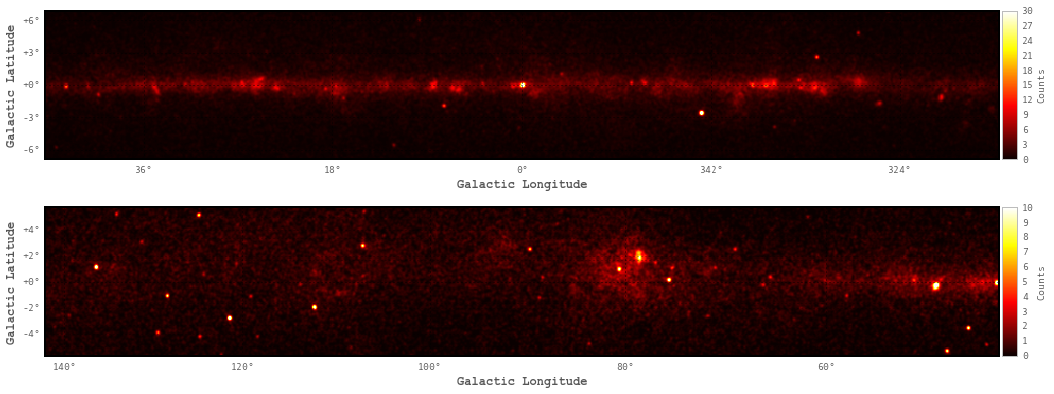

In [17]:
cmap = "/Users/elunejava/Desktop/gt10gev/cmap_10gev_74m_noRockCut.fits"
cbarTitle = 'Counts'
#fig = plt.figure(figsize=[10,50])
fig = plt.figure(figsize=[15,7])
#f = aplpy.FITSFigure(cmap,figure = fig,subplot=(2,1,1))
#f = aplpy.FITSFigure(cmap,figure = fig,subplot=[0.1,0.5,0.9,0.45]) #[xmin, ymin, dx, dy] 
f = aplpy.FITSFigure(cmap,figure = fig,subplot=[0.1,0.51,0.9,0.45])
#f.show_colorscale(vmin =0.0, pmax =100., cmap = 'hot' ,stretch = 'linear') 
f.show_colorscale(vmin= 0,vmax = 30,cmap = 'hot',smooth = 1, stretch = 'linear')
#f.show_grid()
f.tick_labels.set_xformat('ddd')
f.tick_labels.set_yformat('ddd')
#f.frame.set_color('black')
f.frame.set_linewidth(2)
f.add_colorbar()
f.axis_labels.set_font(size='large',weight='bold')
f.tick_labels.set_font(weight = 'bold')
#f.add_label(0.5, 1.1, text = figTitle, relative = True, weight = 'medium', size='large')
f.colorbar.set_axis_label_text(cbarTitle)
#f.colorbar.set_font(size='large',weight = 'bold')
#f.colorbar.set_axis_label_font(size='large',weight='bold')
#f.colorbar.set_ticks(ticks = plt.MaxNLocator(integer = True))
f.recenter(x= 0, y =0, height = 14, width =90)
#f.hide_xaxis_label()
#f.hide_xtick_labels()
#f.hide_grid()

#g = aplpy.FITSFigure(cmap,figure = fig,subplot=(2,1,2))
#g = aplpy.FITSFigure(cmap,figure = fig,subplot=[0.1,0.1,0.9,0.45])
g = aplpy.FITSFigure(cmap,figure = fig,subplot=[0.1,0.1,0.9,0.49])
g.show_colorscale(vmin =0.0, vmax =10., cmap = 'hot' ,smooth = 1, stretch = 'linear') 
#g.show_grid()
g.tick_labels.set_xformat('ddd')
g.tick_labels.set_yformat('ddd')
g.frame.set_color('black')
g.frame.set_linewidth(2)
g.add_colorbar()
g.axis_labels.set_font(size='large',weight='black')
g.tick_labels.set_font(weight = 'black')
#g.add_label(0.5, 1.1, text = figTitle, relative = True, weight = 'medium', size='large')
g.colorbar.set_axis_label_text(cbarTitle)
#g.colorbar.set_font(size='large',weight = 'bold')
#g.colorbar.set_axis_label_font(size='large',weight='bold')
#g.colorbar.set_ticks(ticks = plt.MaxNLocator(integer = True))
g.recenter(x= 90, y =0, height = 14, width =90)
#fig.canvas.draw()
#plt.savefig('/Users/elunejava/Desktop/gt10gevCmap_')

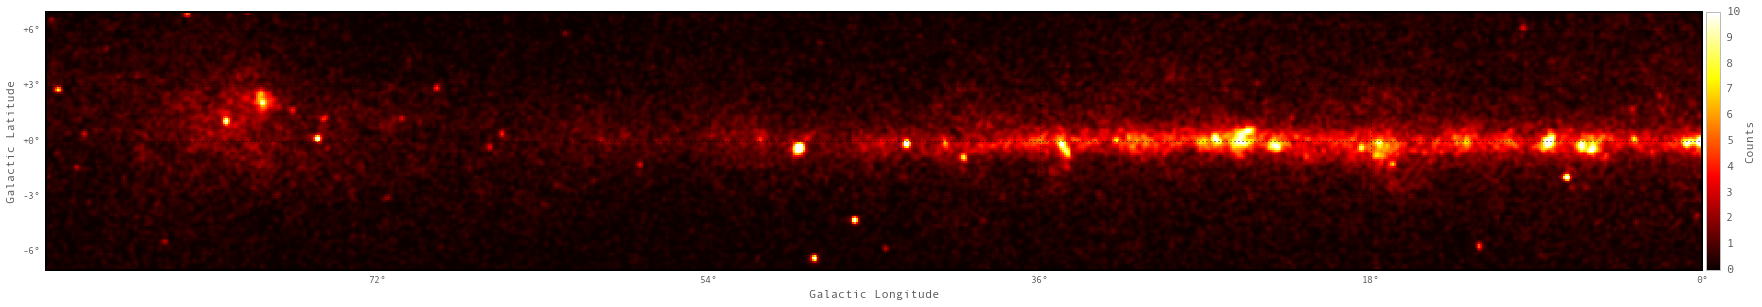

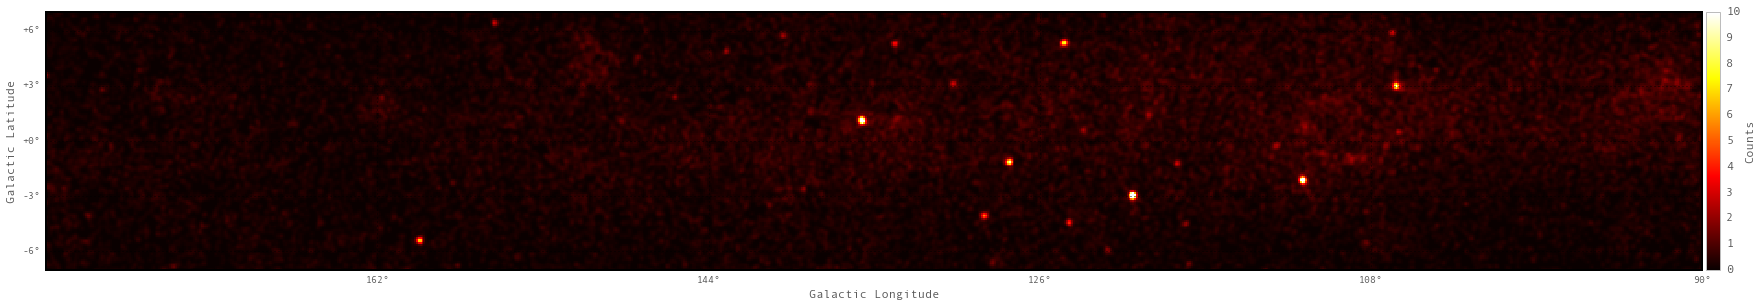

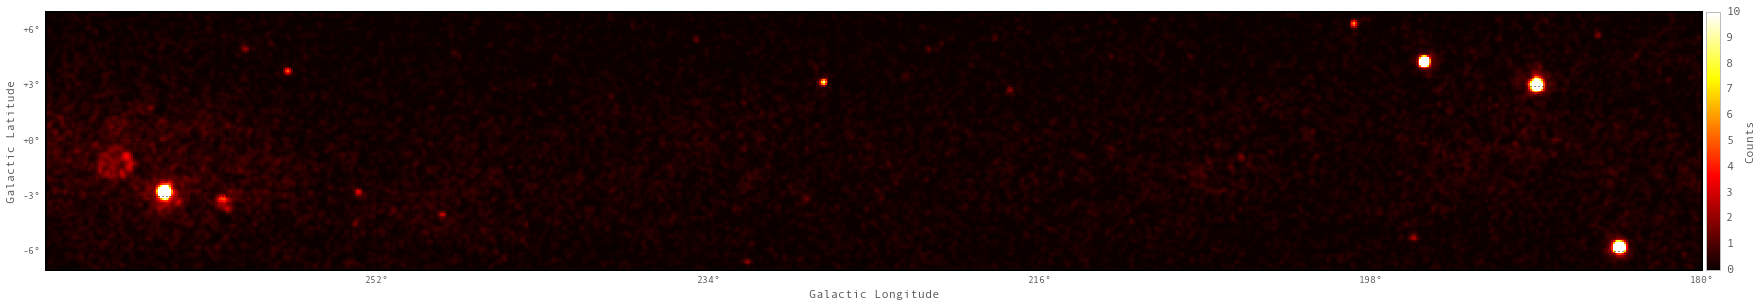

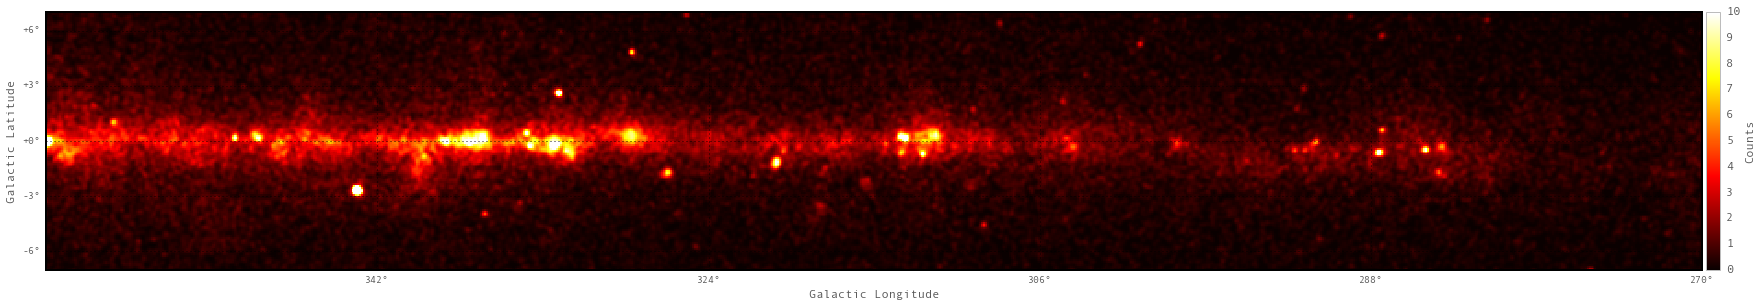

In [13]:
#same as above, but just a sinlge map
#cmap = "/Users/elunejava/Desktop/gt10gev/cmap_10gev_74m_noRockCut.fits"
cmap  = "/Users/elunejava/Desktop/ft1_1gev_7yr_noRockZmax105_cmap.fits"
cbarTitle = 'Counts'
#fig = plt.figure(figsize=[10,50])
for l in [45,135,225,315]:#[0,90,180,270]:
    fig = plt.figure(figsize=[30,14])
    f = aplpy.FITSFigure(cmap,figure = fig)
    #f.show_colorscale(vmin =0.0, pmax =100., cmap = 'hot' ,stretch = 'linear') 
    f.show_colorscale(vmin= 0,vmax = 10,cmap = 'hot',smooth = 1, stretch = 'linear')
    #f.show_grid()
    f.tick_labels.set_xformat('ddd')
    f.tick_labels.set_yformat('ddd')
    f.frame.set_color('black')
    f.frame.set_linewidth(2)
    f.add_colorbar()
    f.axis_labels.set_font(size='large',weight='black')
    f.tick_labels.set_font(weight = 'black')
    #f.add_label(0.5, 1.1, text = figTitle, relative = True, weight = 'medium', size='large')
    f.colorbar.set_axis_label_text(cbarTitle)
    f.colorbar.set_font(size='large',weight = 'black')
    f.colorbar.set_axis_label_font(size='large',weight='black')
    #f.colorbar.set_ticks(ticks = plt.MaxNLocator(integer = True))
    f.recenter(x= l, y =0, height = 14, width =90)
    plt.savefig('/Users/elunejava/Desktop/gt10gevCmap_l%s.png' %(l))#,dpi = 500)
    del f

In [17]:
cmap  = "/Users/elunejava/Desktop/ft1_1gev_7yr_noRockZmax105_cmap.fits"
#the name of this map was wrong, I renamed it at SLAC but not here.
#it is indeed >10GeV
#should I make a zmax = 100 one as well?
cbarTitle = 'Counts'
#fig = plt.figure(figsize=[60,28])
fig = plt.figure(figsize=[30,40])
f = aplpy.FITSFigure(cmap,figure = fig)
#f.show_colorscale(vmin =0.0, pmax =100., cmap = 'hot' ,stretch = 'linear') 
f.show_colorscale(vmin= 0,vmax = 10,cmap = 'hot',smooth = 1, stretch = 'linear')
#f.show_colorscale(vmin =1, pmax =100., cmap = 'hot' ,smooth = 1,stretch = 'log') 
#f.show_grid()
f.recenter(x= 0, y =0, height = 18, width =360)
f.frame.set_color('black')
f.frame.set_linewidth(2)
f.hide_xaxis_label()
f.hide_xtick_labels()
f.hide_yaxis_label()
f.hide_ytick_labels()
plt.tight_layout(pad = 1)
plt.savefig('/Users/elunejava/Dropbox/CurrentWork/G150/allSkyMaps/gt10gevCmap_b9_bb.png',bbox_inches='tight',transparent=True,dpi = 360)
plt.savefig('/Users/elunejava/Dropbox/CurrentWork/G150/allSkyMaps/gt10gevCmap_b9.png',transparent=True,dpi = 360)
f.show_xaxis_label()
f.show_xtick_labels()
f.show_yaxis_label()
f.show_ytick_labels()
f.tick_labels.set_xformat('ddd')
f.tick_labels.set_yformat('ddd')
f.add_colorbar()
f.axis_labels.set_font(size='large',weight='black')
f.tick_labels.set_font(weight = 'black')
#f.add_label(0.5, 1.1, text = figTitle, relative = True, weight = 'medium', size='large')
f.colorbar.set_axis_label_text(cbarTitle)
f.colorbar.set_font(size='large',weight = 'black')
f.colorbar.set_axis_label_font(size='large',weight='black')
#f.colorbar.set_ticks(ticks = plt.MaxNLocator(integer = True))
plt.tight_layout()
plt.savefig('/Users/elunejava/Dropbox/CurrentWork/G150/allSkyMaps/gt10gevCmap_b9_cbarNCoords_bb.png',bbox_inches='tight',dpi = 360)
plt.savefig('/Users/elunejava/Dropbox/CurrentWork/G150/allSkyMaps/gt10gevCmap_b0_cbarNCoords.png',dpi = 360)


del f

#try logscale 

In [ ]:
#what vmax
#maybe make tick marks every 45
#bolder font
#make another without the colorbar
#make a log scale plot and use default settting? pmax = 100?
#larger individual maps?

# Test reading in and parsing xml
### The goal is to be able to make a single xml file with all the relevant source info

### Try quick with beautiful soup


In [241]:
#first get all the xml files
os.chdir(galPlaneDir)
allXmls = {[p for p in os.path.abspath(dirpath).split('/') if p.startswith('Region')][0]:os.path.join(dirpath, f) for dirpath, dirnames, files in os.walk(galPlaneDir) for f in fnmatch.filter(files, 'TSgt16_gtlike.xml' %locals())}
#regResDictsAll = {[p for p in os.path.abspath(dirpath).split('/') if p.startswith('Region')][0]:os.path.join(dirpath, f) for dirpath, dirnames, files in os.walk(galPlaneDir) for f in fnmatch.filter(files, 'results_.yaml' %locals())} #this only works if I'm in 2FHL dir

In [284]:
#try getting the xml for all maxDats
maxDatXmls = {[p for p in os.path.abspath(dirpath).split('/') if p.startswith('Region')][0]:os.path.join(dirpath, f) for dirpath, dirnames, files in os.walk(galPlaneDir) for f in files if f.endswith('xml')}
#maxDat = max([int(i.strip('ES_').split('_')[0]) for i in glob.glob('*.xml') if i.startswith('ES')])

IndexError: list index out of range

In [285]:
# for dirpath, dirnames, files in os.walk(galPlaneDir):   
#     if not '10gev_prunedTSlt25Srcs.reg' in files and not 'l315_b0_ES_6CountsMaps_10gev_zero.eps' in files and len(files) > 1 and not 'results_just3FGL.yaml' in files: #this is hacky to avoid those dirs
#         print files
#         for f in fnmatch.filter(files, max([int(i.strip('ES_').split('_')[0]) for i in glob.glob('*.xml') if i.startswith('ES_')])): #this only works if I'm in 2FHL dir
#             print f

# for dirpath, dirnames, files in os.walk(galPlaneDir):
#     for f in files:
#         if f.endswith('xml'):
#             print f

In [ ]:
for dirpath, dirnames, files in os.walk(galPlaneDir):   
    for f in files:
        if f.startswith('ES_'):
            print f
        #glob.glob('ES*.xml')
    #for f in fnmatch.filter(files, max([int(i.strip('ES_').split('_')[0]) for i in glob.glob('*.xml') if i.startswith('ES')])):
    #   print f
    

In [257]:
files

['.DS_Store',
 '10gev_prunedTSlt25Srcs.reg',
 '10gev_prunedTSlt25Srcs_justES.reg',
 'BsubLogGalPlane_G150.dat',
 'BsubLogGalPlane_l30.dat',
 'BsubLogGalPlane_reload.dat',
 'galPlane10gevResPanelFin.dat',
 'makeTemplatesLog.dat',
 'oldNewDict.pickle',
 'pruned10gevTSgt16.xml',
 'pruned10gevTSgt25.xml',
 'prunedTSlt16Srcs_afterFinYam.reg',
 'prunedTSlt25Srcs_afterDel_srcDF.reg',
 'prunedTSlt25Srcs_afterFinYam.reg',
 'prunedTSlt25Srcs_justES.reg']

In [147]:
#got this from https://stackoverflow.com/questions/22273985/python-how-to-combine-data-from-multiple-xml-files
#test quick with two xmls
first = BeautifulSoup(open(allXmls.values()[0]), "lxml")
#print first.prettify()
#first_as_dict = dict([(x.text, x.parent()) for x in first.find_all("source")])
#print first_as_dict
# second = BeautifulSoup(open(allXmls.values()[1]), "lxml")
# # The actual tag name in your sample XML is "product_code",
# # its not "SKU" as in the first one, change this if that is not correct
# second_as_dict = dict([(x.text, x.parent()) for x in second.find_all("source")])

# combined = BeautifulSoup("", "lxml")

# for key, value in first_as_dict.iteritems():
#     product_tag = combined.new_tag("product")
#     items = value + second_as_dict[key]
#     for item in items:
#         product_tag.append(item)
#     combined.append(product_tag)

# print(combined.prettify())

In [234]:
#for some reason, I have to do combined25/16 separately
diffNames = ['Galactic Diffuse (template_4years_P8_V2_scaled.fits)','Isotropic Diffuse (isotropic_source_4years_P8V3_extrapolated.txt)']
#combined25 = BeautifulSoup("", "lxml")
combined16 = BeautifulSoup("", "lxml")
#notInPruned = []
for reg in allXmls:
    xml = BeautifulSoup(open(allXmls.get(reg)), "lxml")
    for x in xml.find_all("source"): #x is all the source elements
#         if x.get('name') in srcDF_pruned_ts25.index:#oldNewDict.values():
#             combined25.append(x)
        if x.get('name') in srcDF_pruned_ts16.index:
            combined16.append(x)
#         else:
#             if not x.get('name') in diffNames: notInPruned.append(x.get('name')) 
            #print x.get('name'), srcDF_pruned_ts25.loc[x.get('name')]
        #print x.get('name'), '\n' #x.get gets the attributes of the source (so just name/type)
    #print(combined.prettify())

# with open("jam10gevAllTSgt25.xml", "wb") as f:
#     f.write(combined25.prettify())
with open("jam10gevAllTSgt16.xml", "wb") as f:
    f.write(combined16.prettify())

In [217]:
#print notInPruned
#I' missing pulsars because I don't add them to the ts25 DF?

l310_b0_PS_8
l310_b0_PS_7
l310_b0_PS_14
l310_b0_PS_10
l310_b0_PS_1
l310_b0_PS_4
l310_b0_PS_2
l310_b0_PS_12
PSRJ1459-6053_l310_b0
PSRJ1509-5850_l310_b0
Galactic Diffuse (template_4years_P8_V2_scaled.fits)
Isotropic Diffuse (isotropic_source_4years_P8V3_extrapolated.txt)
l310_b0_ES_3
l310_b0_ES_4
l310_b0_ES_5


In [235]:
print len(srcDF_pruned_ts16),len(combined16)


334 334


# This is to get all the maxDat xmls so I can pull PSRs out

In [15]:
#gets all xmls in all dirs
manyXmls = [os.path.join(dirpath, f) for dirpath, dirnames, files in os.walk(galPlaneDir) for f in fnmatch.filter(files, '*.xml' %locals()) if (os.path.abspath(dirpath).split('/')[-3]).startswith('Region_')] #3 snrs that don't have a final yaml
# take the ones's that start with ES
xmls = [x for x in manyXmls if os.path.basename(x).startswith('ES_')]
#make a dict of {region:{ESnum:ESnumXML}}
xmlDict = defaultdict(lambda: defaultdict(dict))
for x in xmls:
    num = int(os.path.basename(x).split('_')[1])
    #print x.split, num, x
    xmlDict[x.split('/')[-4]][num] = x

In [16]:
#make a list of lists with each list being all the xmls in an RoI
maxDatXml = []
for reg,nums in xmlDict.items(): #reg is the region, nums is a dict of ES#: xml path
    inner = []
    for xmlf in nums.values():
        inner.append(xmlf)
    maxDatXml.append(inner)

In [17]:
#list of maxDat xml for each region
finMaxXml = []
for reg in maxDatXml: #reg is list of xmls for each region
    maxx = 0
    index = 0
    for ind, f in enumerate(reg):
        num = os.path.basename(f).split('_')[1]
        if num > maxx: 
            maxx = num
            index = ind
    finMaxXml.append(reg[ind])
        

## Next make single xml with all maxDat xmls
### It works right, except it has the pulsars as PSR Jblah, and not PSRJblah

In [202]:
#since the maxDat xmls don't have the same name conventions as here
#add the regular PSR names as a col to the DF
psrNames = srcDF_pruned_ts25[srcDF_pruned_ts25.index.str.startswith('PSR')].index.str.replace('PSR','PSR ').str.split('_').str.get(0)
psrSer = pd.Series(psrNames,srcDF_pruned_ts25[srcDF_pruned_ts25.index.str.startswith('PSR')].index)
srcDF_pruned_ts25['oldName'] = psrSer

#same but for TS16
psrNames = srcDF_pruned_ts16[srcDF_pruned_ts16.index.str.startswith('PSR')].index.str.replace('PSR','PSR ').str.split('_').str.get(0)
psrSer = pd.Series(psrNames,srcDF_pruned_ts16[srcDF_pruned_ts16.index.str.startswith('PSR')].index)
srcDF_pruned_ts16['oldName'] = psrSer

/Users/elunejava/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [205]:
#finMaxXml
#I don't want all PSRs, only the ones that make the TS cuts
#then replace the old bad params one with the new ones
once = []
os.chdir(galPlaneDir)
diffNames = ['Galactic Diffuse (template_4years_P8_V2_scaled.fits)','Isotropic Diffuse (isotropic_source_4years_P8V3_extrapolated.txt)']
combined25 = BeautifulSoup("", "lxml")
#combined16 = BeautifulSoup("", "lxml")
for reg in finMaxXml:
    xml = BeautifulSoup(open(reg), "lxml")
    for x in xml.find_all("source"): #x is all the source elements
        if x.get("name") in srcDF_pruned_ts25.oldName.tolist() and x.get("name").startswith("PSR") and x.get("name") not in once:#oldNewDict.values():
            once.append(x.get("name"))
            x.attrs['name'] = srcDF_pruned_ts25[srcDF_pruned_ts25.oldName == x.get("name")].index[0]
            combined25.append(x)
#         if x.get("name") in srcDF_pruned_ts16.oldName.tolist() and x.get("name").startswith("PSR") and x.get("name") not in once:#oldNewDict.values():
#             once.append(x.get("name"))
#             x.attrs['name'] = srcDF_pruned_ts16[srcDF_pruned_ts16.oldName == x.get("name")].index[0]
#             combined16.append(x)

with open("jam10gevTS25maxDat.xml", "wb") as f:
    f.write(combined25.prettify())
# with open("jam10gevTS16maxDat.xml", "wb") as f:
#     f.write(combined16.prettify())